# Condition Monitoring of Air Pressure Systems (APS)

## Introduction

Large vehicles primarily rely on Air Pressure System (APS) as a means to control the brakes and gears. Failures in either systems usually have fatal consequences as trucks and buses have the highest fatality rate per accident worldwide. Apart from the fatalities, there is also a large monetary loss whenever there is an unexpected breakdown. Firstly, the vehicle(s) will not be able to make pickups nor deliveries for some time. Secondly, the vehicle / system will typically be much more expensive to repair, compared to just doing preventive maintenance. 

In this notebook we will apply several machine learning techniques to classify the condition of an APS system to determine if it is at risk of failure. In doing so we can:

1. Improve the reliability of the APS system.
2. Augment the decision making of the technicians, mechanics, dispatchers and supply chain managers.
3. Reduce the cost associated with maintaining the vehicles.
4. Reduce accidents involving large vehicles.


## Scope and Limitations

The dataset is an imbalanced binary classification problem where failures are rare occurences. There is an associated cost in for each wrong prediction that we must minimize; false positive and false negative are 10 Euros and 500 Euros respectively. One major limitation of this project is that the variables used have been masked as it is proprietary data. And so we cannot infer causality between the target variables and the features. Null values are also present in the dataset, imputing these values will introduce errors which could affect the explainability of the resulting model.

## Import Packages

In [1]:
import eif
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pickle as pkl
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from lightgbm import Dataset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import random
from sklearn.metrics import precision_recall_curve
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

## Define Functions

In [38]:
def apply_log(value):
    '''
    '''
    if np.isnan(value):
        return value
    else:
        return np.log1p(value)
    
def rescale(df):
    '''
    '''
    for col in df.columns:
        df[col] = df[col].apply(lambda x: apply_log(x))
    
    return df

def load_data(filename):
    '''
    '''
    df = pd.read_csv(filename)
    df = df.replace('na', np.nan)
    df = df.replace('neg', 0)
    df = df.replace('pos', 1)
    df = df.astype(float)
    print(df.shape)
    display(df.head())
    
    return df

def get_label(probability, thresh):
    '''
    '''
    if probability < thresh:
        return 0
    else:
        return 1
    
def estimate_hyperparameters(param_grid, x, y):
    '''
    '''
    cv_results = []
    for i,hyperparams in enumerate(list(ParameterGrid(param_grid))):

        validation_summary = lgb.cv(hyperparams,
                                    Dataset(x_2, label=y_2),
                                    metrics=["auc"],
                                    verbose_eval=25, seed=42)

        # Store the best hyperparameters
        cv_results.append((hyperparams, validation_summary["auc-mean"][-1]))
        
        print(i)
    return sorted(cv_results, key=lambda x: x[1], reverse=True)

def perform_splits(x,y,test_size=0.4):
    '''
    '''

    x_2_train , x_2_val, y_2_train, y_2_val = train_test_split(x, y,
                                                               test_size=test_size)

    x_2_train.columns = x.columns
    x_2_val.columns = x.columns

    # StratifiedKFold executes the k-fold operation in a stratified manner
    skf = StratifiedKFold(n_splits=3)
    skf.get_n_splits(x_2_val, y_2_val)

    # Get the validation sets
    val_inds = [tst for trn, tst in skf.split(x_2_val, y_2_val)]
    validation_sets = [Dataset(x_2_val.values[val_ind],
                               label=y_2_val.values[val_ind])
                       for val_ind in val_inds]
    
    return x_2_train , x_2_val, y_2_train, y_2_val, val_inds, validation_sets
    
def eval_roc_auc(model, x_train, y_train,
                 x_val, y_val, val_inds, 
                 x_test, y_test):
    '''
    '''
    
    fig, ax = plt.subplots(figsize=(5,5), dpi=120)
    
    # Get scores for train set
    y_pred = model.predict(x_train)
    auc = roc_auc_score(y_train, y_pred)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    ax.plot(fpr, tpr, alpha=0.55, label=f'AUC Train: {np.round(auc,3)}')
    
    # Get scores for validation set
    for i, val_ind in enumerate(val_inds):
        y_pred = model.predict(x_val.values[val_ind])
        auc = roc_auc_score(y_val.values[val_ind], y_pred)
        fpr, tpr, thresholds = roc_curve(y_val.values[val_ind], y_pred)
        ax.plot(fpr, tpr, alpha=0.55, label=f'AUC Validation {i}: {np.round(auc,3)}')
    
    # Get scores for test set
    y_pred = model.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, alpha=0.55, label=f'AUC Test: {np.round(auc,3)}')

    
    # Visualization of ROC
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curves')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.grid()
    ax.legend()
    
def eval_prc(model, x_train, y_train,
             x_val, y_val, val_inds,
             x_test, y_test):
    '''
    '''
    fig, ax = plt.subplots(figsize=(5,5), dpi=120)
    
    # Get scores for train set
    y_pred = model.predict(x_train)
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred)
    ax.plot(recall, precision, alpha=0.55, label=f'Train')
    
    
    # Get scores for validation set
    for i, val_ind in enumerate(val_inds):
        y_pred = model.predict(x_val.values[val_ind])
        precision, recall, thresholds = precision_recall_curve(y_val.values[val_ind], y_pred)
        ax.plot(recall, precision, alpha=0.55, label=f'Validation {i}')
    
    # Get scores for test set
    y_pred = model.predict(x_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    ax.plot(recall, precision, alpha=0.55, label=f'Test')
    
    # Visualization of ROC

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'PR Curves')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.grid()
    ax.legend()

def eval_thresh_cost(model, x, y, title, cost_fp=10, cost_fn=500, custom_thresh=None):
    '''
    '''
    costs_fp = []
    costs_fn = []
    for thresh in np.linspace(0,100,201):
        y_pred = model.predict(x)
        ylabel = list(map(lambda x: get_label(x, thresh/100), y_pred))
        tn, fp, fn, tp = confusion_matrix(y, ylabel).ravel()
        costs_fp.append(fp*cost_fp)
        costs_fn.append(fn*cost_fn)
    total_cost = np.array(costs_fp)+np.array(costs_fn)

    if not custom_thresh:
        min_cost = min(total_cost)
        best_thresh = (np.linspace(0,100,201)/100)[total_cost.argmin()]
    else:
        best_i = list(np.linspace(0,100,201)/100).index(custom_thresh)
        best_thresh = (np.linspace(0,100,201)/100)[best_i]
        min_cost = total_cost[best_i]
        
    fig, ax = plt.subplots(figsize=(8,4), dpi=120)
    print(min_cost, best_thresh)
    ax.plot(np.linspace(0,100,201)/100, costs_fp, label='False Positives Cost')
    ax.plot(np.linspace(0,100,201)/100, costs_fn, label='False Negative Cost')
    ax.plot(np.linspace(0,100,201)/100, total_cost, label=f'Total Cost (Cost: {min_cost} @ thresh: {best_thresh})')
    ax.set_ylabel('Cost (Euros)')
    ax.set_xlabel('Threshold')
    ax.set_title(title)
    ax.set_yscale('log')
    ax.legend()
    ax.grid()
    
    if not custom_thresh:
        return best_thresh

## The Data

### Training Set

In [3]:
df_train = load_data('aps_failure_training_set.csv')

(60000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


### Test Set

In [4]:
df_test = load_data('aps_failure_test_set.csv')

(16000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,60.0,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,0.0,82.0,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,0.0,66002.0,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,0.0,59816.0,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,0.0,1814.0,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


## Exploratory Data Analysis and Cleaning

### Class Label Distribution

The labels of the dataset is unbalanced, wherein there are only 1000 instances of near failures out of 60000 samples. We thus need to balance the dataset either through oversampling of the minority class or undersampling of the majority class. In addition, we can only use the AUC, F1, precision and recall to evaluate the performance of our model.

1000


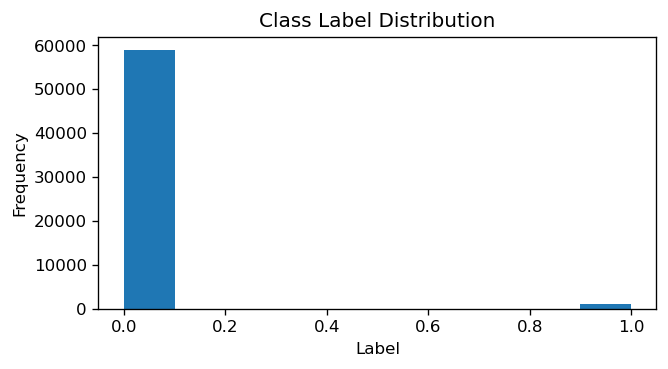

In [5]:
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
df_train['class'].hist(ax=ax)
ax.set_title('Class Label Distribution')
ax.set_ylabel('Frequency')
ax.set_xlabel('Label')
ax.grid()
print(df_train[df_train['class']>0].shape[0])

### Null Handling

The data contains several null values, with some columns being comprised of more than 50% nulls. Since the variables are masked, there's no way for us to know what these variables mean, nor if there's any causality with the target variable. Imputing such a high percentage of unkown values is especially dangerous in the context of APS predictive maintenance.

Text(0.5, 0, 'Percentage')

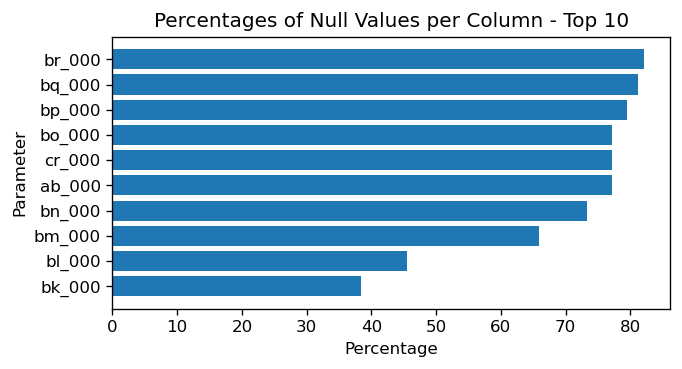

In [6]:
null_stats = (100*df_train.isnull().sum(axis=0)/df_train.shape[0]).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
ax.barh(null_stats.iloc[-10:].index, null_stats.iloc[-10:])
ax.set_title('Percentages of Null Values per Column - Top 10')
ax.set_ylabel('Parameter')
ax.set_xlabel('Percentage')

However, if we were to drop rows / columns just because there are NaN values, we will be dropping a large chunk of our dataset.

In [7]:
print(df_train.dropna(how='any', axis=1).shape)
print(df_train.dropna(how='any').shape)

(60000, 2)
(591, 171)


We will opt for a middle point between the two approaches. Rows and columns that exceed a certain threshold of null quantities will be dropped and the remaining nulls will be imputed. The code below shows the distribution of the null percentages along the rows and columns which will aid in identifying an appropriate threshold.

Text(0, 0.5, 'Frequency')

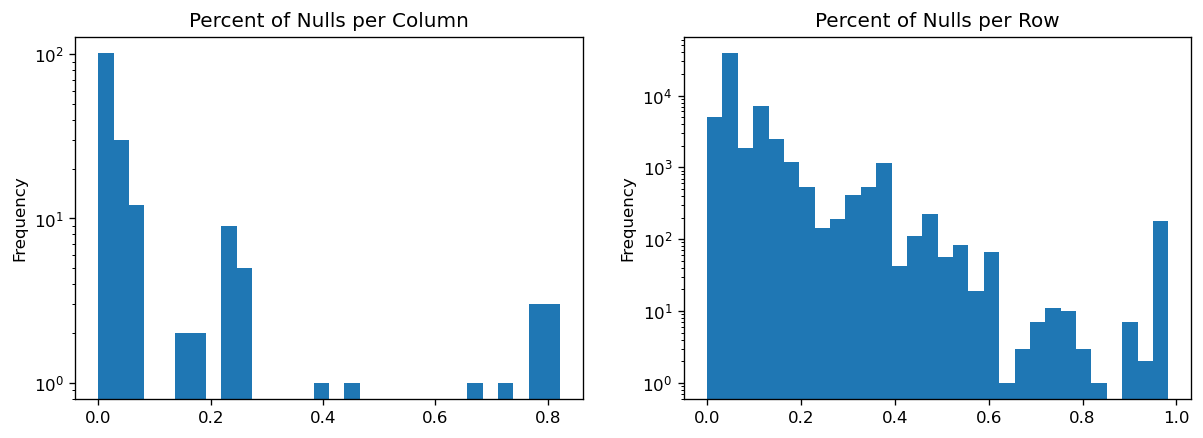

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=120)
(df_train.isnull().sum(axis=0)/df_train.shape[0]).hist(bins=30, ax=ax[0])
(df_train.isnull().sum(axis=1)/df_train.shape[1]).hist(bins=30, ax=ax[1])
ax[0].set_title('Percent of Nulls per Column')
ax[0].set_yscale('log')
ax[0].grid()
ax[0].set_ylabel('Frequency')
ax[1].set_title('Percent of Nulls per Row')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_ylabel('Frequency')

Columns and rows that contain more than 10% and 40% nulls respectively will be removed to reduce the amount of imputation needed. The end result is that we are left with `143` columns (inclusive of the target variable) along with `58329` (out of 59000) rows tagged as 0s and `995` (out of 1000) rows tagged as 1s.

In [9]:
df_cols3 = df_train.isnull().sum(axis=0)/df_train.shape[0]
df_cols3 = df_cols3[df_cols3<0.1]
len(df_cols3.index)

143

In [10]:
Counter(df_train[df_train[df_cols3.index].isnull().sum(axis=1)/df_train.shape[1]<0.40][df_cols3.index]['class'])

Counter({0.0: 58329, 1.0: 995})

In [11]:
df_train = df_train[df_train[df_cols3.index].isnull().sum(axis=1)/df_train.shape[1]<0.40][df_cols3.index]

### Check for Categorical or Continuous Variables

We must check if the variable is categorical or not so that we can apply the appropriate statistical tests. The code below counts the number of unique variables in a dataframe. The higher the count, the more likely it is to be a continuous variable. From here it seems that only `cd_0000` looks to be a categorical variable.

In [12]:
df_nunique = df_train.nunique(axis=0,
                              dropna=False).sort_values(ascending=True)
display(df_nunique.iloc[:10])

class      2
cd_000     2
as_000    21
ef_000    29
dz_000    48
eg_000    50
cs_009    53
au_000    57
ar_000    69
dj_000    73
dtype: int64

Checking `cd_0000` shows that it either has constant or a null value. We will drop this column from the modelling since it doesn't add any information due to it being a constant.

In [13]:
list(Counter(df_train['cd_000']).items())[:5]

[(1209600.0, 58842), (nan, 1), (nan, 1), (nan, 1), (nan, 1)]

In [14]:
df_train = df_train.drop('cd_000', axis=1)

### Check Distributions for Normality

Based on `D’Agostino’s K^2` test, it seems that none of our columns follow a normal distribution. This violates the assumption of `pearson's correlation test`. As such, we can either use `spearman's correlation test` or an ML approach with a built in feature importance (e.g. tree-based algorithms) to select which features to use.

In [15]:
normality = []
for col in df_train.columns:
    
    k2, p = normaltest(df_train[col], nan_policy='omit')
    alpha = 0.05
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        normality.append((col, 'not normal'))
    else:
        normality.append((col, 'normal'))
        
print(f'First 15 columns:\n{normality[:15]}')

First 15 columns:
[('class', 'not normal'), ('aa_000', 'not normal'), ('ac_000', 'not normal'), ('ae_000', 'not normal'), ('af_000', 'not normal'), ('ag_000', 'not normal'), ('ag_001', 'not normal'), ('ag_002', 'not normal'), ('ag_003', 'not normal'), ('ag_004', 'not normal'), ('ag_005', 'not normal'), ('ag_006', 'not normal'), ('ag_007', 'not normal'), ('ag_008', 'not normal'), ('ag_009', 'not normal')]


### Visualization on a Subset of Columns

Majority, of the distributions follow a power law distribution with some variables having exceedingly high values. To address this we will apply log-scaling since other scaling methods will result in a very skewed transformation.

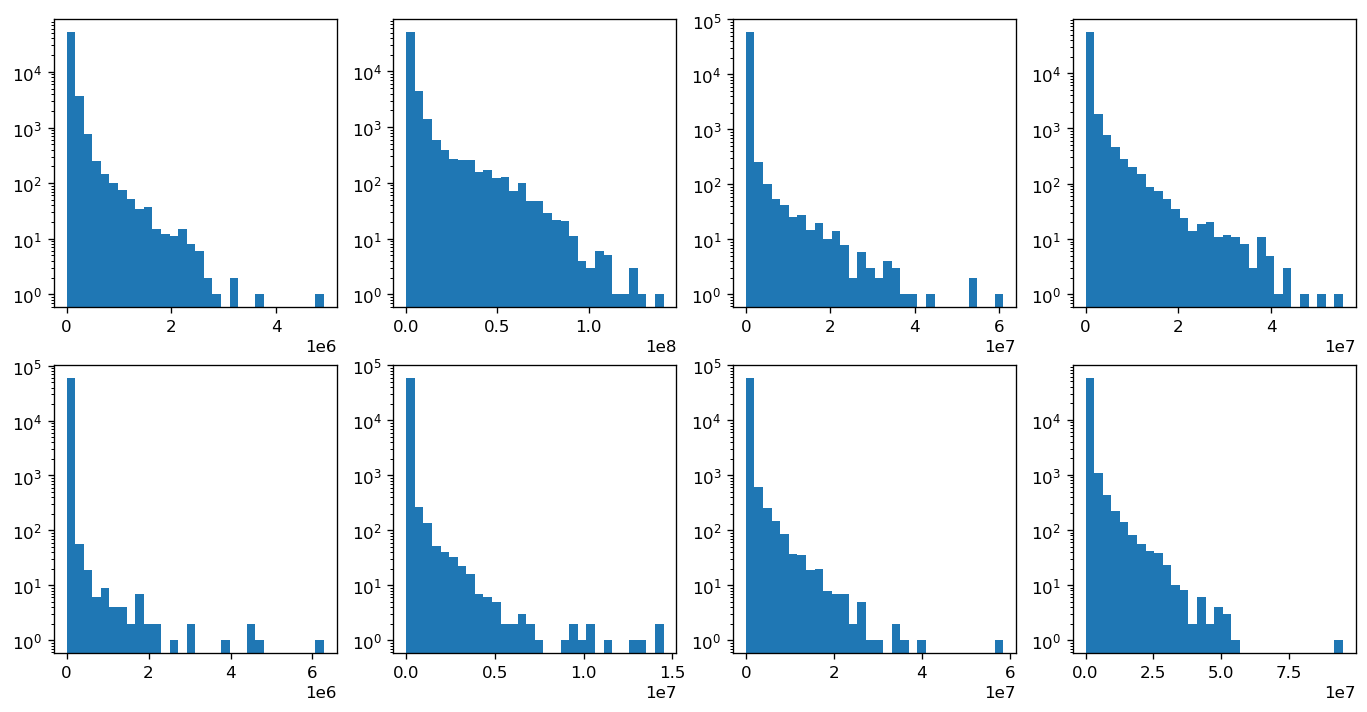

In [16]:
fig, ax = plt.subplots(2,4,figsize=(14,7), dpi=120)
for i, col in enumerate(df_train.columns[80:88]):
    if i < 4:
        j=0
    else:
        j=1
    df_train[col].hist(ax=ax[j][i%4], bins=30)
    ax[j][i%4].set_yscale('log')
    ax[j][i%4].grid()

## Rescaling and Imputing Nulls

Most of the datapoints follow a power law distribution wherein exponentially high values are a rare occurence. Log-scaling the data will make it such that the distribution is retained but the distance between values will be smaller. This will greatly help in reducing the scale of the computations for our model (thus avoiding an exploding gradient problem). Since the distribution seems to follow a power law distribution, imputation will be done via the mode.

In [17]:
x = df_train[df_train.columns[1:]]
x = rescale(x)
y = df_train['class']

imputer = SimpleImputer(strategy='most_frequent')
x = imputer.fit_transform(x)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Outlier Analysis

Model performance can be negatively affected by outlying data points. As such it may be useful to analyze the outliers in the data set prior to modelling. Since the data is high dimensional (142 features) we will use an ML approach to checking for outliers.

Our chosen Outlier Detection approach is via the Extended Isolation Forest (EIF) algorithm (an improvement over Isolation Forest (IF)) which bisects the hyperplanes in multiple dimensions at each iteration. The idea of EIF is the same as IF wherein a datapoint's anomaly score is higher if it can be easily isolated from the rest of the datapoints. EIF solves the issues of imaginary dense clusters forming up in areas of low density. For more details on EIF you can check this paper: https://arxiv.org/pdf/1811.02141.pdf

A `sample_size` of 5000 was chosen to ensure that the distribution is somewhat preserved. The `number of tree estimators` was set to 125 to ensure that multiple subset of features will be explored by the model. Finally, an `ExtensionLevel` of 71 was chosen such that the model is bisecting the hyperplane 71 dimensions at a time (1/2 of all dimensions). Adding more extension levels does not necessarily improve performance, but it would certainly increase the computational complexity. By intersecting only half of all dimensions it gives the model some degree of freedom.

In [ ]:
eif_71 = eif.iForest(X, ntrees=125, sample_size=5000, ExtensionLevel=71)
anomaly_scores_71 = eif_71.compute_paths(X_in=X)

The frequency distribution of the anomaly scores can be seen below wherein the higher the score the more anomalous the datapoint is. The distribution is positively skewed. Most of the data points have an anomaly score around 0.40.

Text(0.5, 0, 'Anomaly Score')

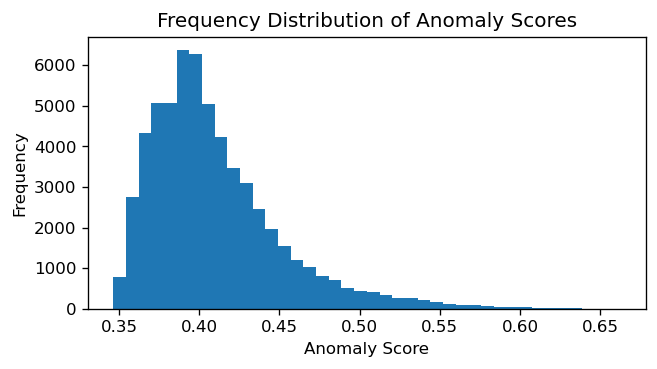

In [19]:
fig, ax = plt.subplots(figsize=(6,3), dpi=120)
ax.hist(anomaly_scores_71, bins=40)
ax.set_title('Frequency Distribution of Anomaly Scores')
ax.set_ylabel('Frequency')
ax.set_xlabel('Anomaly Score')

The code below extracts all the data points that go beyond an arbitrary outlier threshold that we define. **And it turns out that a good portion of our failure events are outlier cases. Infact, just by setting the threshold to 0.45, we are already able to capture 90% of the outlier cases.** In hindsight, this is expected because failure events are supposed to be outliers! If not then the manufactured product (APS) would be downright unreliable.

In [20]:
Counter(y.values[np.where(anomaly_scores_71 > 0.413)])

Counter({0.0: 20793, 1.0: 965})

While EIF is able to capture a lot of the failure events, we also run the risk of having too many false positives. **If we are to use this model as it is, then more than 10% of our negative cases will be flagged.** This is because we have yet to determine which of these variables are actually relevant in identifying APS failures. A high anomaly score doesn't necessarily mean that it is a failure event, because the outlying feature may not even be related to the APS failure to begin with.

## Modelling and Feature Importance

Several modelling experiments were attempted such as:
1. Stacking outlier detection with the LGBM unbalanced classifier.
2. Classifying outlying points in the majority class vs the entire minority class.
3. Performing SMOTE prior to the classification to instead do binary classification.
4. Peforming feature selection and engineering (pairwise subtraction and division of columns).
5. Performing feature selection and engineering then doing PCA.

But only the best approach will be highlighted in this notebook from this point on.

### Training and Test Set Preparation

In [22]:
x = pd.DataFrame(x, columns=df_train.columns[1:])

x_test = df_test[df_train.columns[1:]]
# No droping of rows with many null values
x_test = rescale(x_test)

imputer = SimpleImputer(strategy='most_frequent')
x_test = imputer.fit_transform(x_test)

x_test = pd.DataFrame(x_test)
x_test.columns = df_train.columns[1:]

# No outlier analysis / inlier removal
y_test = df_test['class']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Hyperparameter Tuning

In [24]:
param_grid = {'num_leaves': [70,50,30],
              'min_data_in_leaf': [35,55,75],
              'lambda_l1': [0.00001,0.0001,0.001],
              'lambda_l2': [10,100,1000],
              'bagging_fraction':[0.5],
              'feature_fraction':[0.5],
              'objective':['binary'],'path_smooth':[3],
              'max_depth':[10], 'max_bin':[150],
              'min_gain_to_split':[0.2],
              'learning_rate':[0.1],
              'num_boost_round':[1500],
              'nfold':[5],
              'early_stopping_rounds':[10]}

cv_results = estimate_hyperparameters(param_grid, x, y)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988208 + 0.00610671
[50]	cv_agg's auc: 0.989963 + 0.00678488
[75]	cv_agg's auc: 0.990656 + 0.00606634
0


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988156 + 0.00612231
[50]	cv_agg's auc: 0.990173 + 0.00674609
1


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988034 + 0.00617987
[50]	cv_agg's auc: 0.989897 + 0.006541
[75]	cv_agg's auc: 0.990841 + 0.00547106
2


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988431 + 0.00623158
[50]	cv_agg's auc: 0.989386 + 0.00651393
[75]	cv_agg's auc: 0.990468 + 0.00555792
[100]	cv_agg's auc: 0.990971 + 0.00494219
[125]	cv_agg's auc: 0.991219 + 0.00480605
3


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988412 + 0.00622706
[50]	cv_agg's auc: 0.989843 + 0.00624977
[75]	cv_agg's auc: 0.990522 + 0.0055404
4


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988463 + 0.0061453
[50]	cv_agg's auc: 0.989856 + 0.00687658
[75]	cv_agg's auc: 0.991129 + 0.00533542
[100]	cv_agg's auc: 0.991385 + 0.00496558
5


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988793 + 0.00631264
[50]	cv_agg's auc: 0.98987 + 0.00612626
[75]	cv_agg's auc: 0.990719 + 0.00574319
6


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988793 + 0.00631264
[50]	cv_agg's auc: 0.989826 + 0.00620031
[75]	cv_agg's auc: 0.991136 + 0.0057023
7


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988654 + 0.00628628
[50]	cv_agg's auc: 0.989679 + 0.00624049
[75]	cv_agg's auc: 0.991136 + 0.00517514
8


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671439
[50]	cv_agg's auc: 0.987073 + 0.00636571
[75]	cv_agg's auc: 0.988561 + 0.00555426
[100]	cv_agg's auc: 0.98915 + 0.00568715
[125]	cv_agg's auc: 0.989611 + 0.00617899
[150]	cv_agg's auc: 0.990042 + 0.00621327
[175]	cv_agg's auc: 0.990377 + 0.0060985
[200]	cv_agg's auc: 0.99065 + 0.00593166
[225]	cv_agg's auc: 0.990864 + 0.00581368
[250]	cv_agg's auc: 0.990911 + 0.00582833
[275]	cv_agg's auc: 0.990979 + 0.00574761
[300]	cv_agg's auc: 0.991088 + 0.00560293
9


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671439
[50]	cv_agg's auc: 0.987073 + 0.00636571
[75]	cv_agg's auc: 0.988561 + 0.00555426
[100]	cv_agg's auc: 0.98915 + 0.00568715
[125]	cv_agg's auc: 0.989611 + 0.00617899
[150]	cv_agg's auc: 0.990042 + 0.00621327
[175]	cv_agg's auc: 0.990377 + 0.0060985
[200]	cv_agg's auc: 0.99065 + 0.00593166
[225]	cv_agg's auc: 0.990864 + 0.00581368
[250]	cv_agg's auc: 0.990911 + 0.00582833
[275]	cv_agg's auc: 0.990979 + 0.00574761
[300]	cv_agg's auc: 0.991088 + 0.00560293
10


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671433
[50]	cv_agg's auc: 0.987049 + 0.00633896
[75]	cv_agg's auc: 0.988451 + 0.00557044
11


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
12


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
13


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
14


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
15


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
16


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
17


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581361
[450]	cv_agg's auc: 0.98769 + 0.00586465
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600067
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581361
[450]	cv_agg's auc: 0.98769 + 0.00586465
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600067
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581361
[450]	cv_agg's auc: 0.98769 + 0.00586465
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600067
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571865
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571865
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571865
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988208 + 0.00610671
[50]	cv_agg's auc: 0.990024 + 0.00680265
[75]	cv_agg's auc: 0.990716 + 0.00607786
[100]	cv_agg's auc: 0.991184 + 0.0054953
27


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988156 + 0.00612231
[50]	cv_agg's auc: 0.990174 + 0.00674611
28


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988323 + 0.00620798
[50]	cv_agg's auc: 0.98968 + 0.00650083
[75]	cv_agg's auc: 0.990679 + 0.00547818
[100]	cv_agg's auc: 0.990949 + 0.00500444
29


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988431 + 0.00623158
[50]	cv_agg's auc: 0.989386 + 0.00651393
[75]	cv_agg's auc: 0.990468 + 0.00555792
[100]	cv_agg's auc: 0.990971 + 0.00494219
[125]	cv_agg's auc: 0.991219 + 0.00480621
30


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988412 + 0.00622706
[50]	cv_agg's auc: 0.989774 + 0.00625441
[75]	cv_agg's auc: 0.990446 + 0.00552263
31


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988463 + 0.0061453
[50]	cv_agg's auc: 0.989856 + 0.00687658
[75]	cv_agg's auc: 0.991129 + 0.00533542
[100]	cv_agg's auc: 0.991385 + 0.00496558
32


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988793 + 0.00631264
[50]	cv_agg's auc: 0.98987 + 0.00612626
[75]	cv_agg's auc: 0.990719 + 0.00574319
33


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988793 + 0.00631264
[50]	cv_agg's auc: 0.989826 + 0.00620031
[75]	cv_agg's auc: 0.991136 + 0.0057023
34


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988654 + 0.00628628
[50]	cv_agg's auc: 0.989679 + 0.00624049
[75]	cv_agg's auc: 0.991136 + 0.00517514
35


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671439
[50]	cv_agg's auc: 0.987073 + 0.00636571
[75]	cv_agg's auc: 0.988561 + 0.00555426
[100]	cv_agg's auc: 0.98915 + 0.00568715
[125]	cv_agg's auc: 0.989611 + 0.00617916
[150]	cv_agg's auc: 0.990043 + 0.0062131
[175]	cv_agg's auc: 0.990377 + 0.0060985
[200]	cv_agg's auc: 0.99065 + 0.00593166
[225]	cv_agg's auc: 0.990864 + 0.00581385
[250]	cv_agg's auc: 0.990911 + 0.00582833
[275]	cv_agg's auc: 0.990979 + 0.00574761
[300]	cv_agg's auc: 0.991088 + 0.00560293
36


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671439
[50]	cv_agg's auc: 0.987073 + 0.00636571
[75]	cv_agg's auc: 0.988561 + 0.00555426
[100]	cv_agg's auc: 0.98915 + 0.00568715
[125]	cv_agg's auc: 0.989611 + 0.00617916
[150]	cv_agg's auc: 0.990043 + 0.0062131
[175]	cv_agg's auc: 0.990377 + 0.0060985
[200]	cv_agg's auc: 0.99065 + 0.00593166
[225]	cv_agg's auc: 0.990864 + 0.00581385
[250]	cv_agg's auc: 0.990911 + 0.00582833
[275]	cv_agg's auc: 0.990979 + 0.00574761
[300]	cv_agg's auc: 0.991088 + 0.00560293
37


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671433
[50]	cv_agg's auc: 0.987049 + 0.00633896
[75]	cv_agg's auc: 0.988451 + 0.00557044
38


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
39


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
40


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
41


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
42


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
43


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
44


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581345
[450]	cv_agg's auc: 0.98769 + 0.00586482
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600052
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581345
[450]	cv_agg's auc: 0.98769 + 0.00586482
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600052
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581345
[450]	cv_agg's auc: 0.98769 + 0.00586482
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600052
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571866
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571866
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571866
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988208 + 0.00610671
[50]	cv_agg's auc: 0.990035 + 0.00680539
[75]	cv_agg's auc: 0.990788 + 0.0060862
54


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988158 + 0.0061249
[50]	cv_agg's auc: 0.990151 + 0.0067286
55


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.98804 + 0.0061676
[50]	cv_agg's auc: 0.989502 + 0.00731205
[75]	cv_agg's auc: 0.990629 + 0.00590861
56


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.98843 + 0.00623125
[50]	cv_agg's auc: 0.98938 + 0.00650859
[75]	cv_agg's auc: 0.990478 + 0.00556659
[100]	cv_agg's auc: 0.990986 + 0.00499073
[125]	cv_agg's auc: 0.991211 + 0.00467073
57


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988412 + 0.00622706
[50]	cv_agg's auc: 0.989757 + 0.00624089
[75]	cv_agg's auc: 0.990473 + 0.0055449
58


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.98844 + 0.00613928
[50]	cv_agg's auc: 0.99007 + 0.00693803
[75]	cv_agg's auc: 0.99126 + 0.00525532
59


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988807 + 0.00631527
[50]	cv_agg's auc: 0.989701 + 0.00644241
[75]	cv_agg's auc: 0.990639 + 0.00598854
60


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988807 + 0.00631527
[50]	cv_agg's auc: 0.989828 + 0.0062017
[75]	cv_agg's auc: 0.991186 + 0.00570006
61


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988654 + 0.00628627
[50]	cv_agg's auc: 0.989686 + 0.00624653
[75]	cv_agg's auc: 0.991384 + 0.00477839
62


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671454
[50]	cv_agg's auc: 0.987073 + 0.00636577
[75]	cv_agg's auc: 0.988561 + 0.00555464
[100]	cv_agg's auc: 0.989162 + 0.00566335
[125]	cv_agg's auc: 0.989694 + 0.00602229
[150]	cv_agg's auc: 0.990095 + 0.00611222
[175]	cv_agg's auc: 0.990339 + 0.00617269
[200]	cv_agg's auc: 0.990536 + 0.00615084
[225]	cv_agg's auc: 0.990718 + 0.00606162
[250]	cv_agg's auc: 0.990792 + 0.00602132
63


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671454
[50]	cv_agg's auc: 0.987073 + 0.00636577
[75]	cv_agg's auc: 0.988561 + 0.00555464
[100]	cv_agg's auc: 0.989162 + 0.00566335
[125]	cv_agg's auc: 0.989694 + 0.00602229
[150]	cv_agg's auc: 0.990095 + 0.00611222
[175]	cv_agg's auc: 0.990339 + 0.00617269
[200]	cv_agg's auc: 0.990536 + 0.00615084
[225]	cv_agg's auc: 0.990718 + 0.00606162
[250]	cv_agg's auc: 0.990792 + 0.00602132
64


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983338 + 0.00671467
[50]	cv_agg's auc: 0.987049 + 0.00633883
[75]	cv_agg's auc: 0.988451 + 0.00557042
65


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
66


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
67


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
68


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619328
69


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619328
70


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619328
71


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.00654347
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553266
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550818
[325]	cv_agg's auc: 0.987128 + 0.00554547
[350]	cv_agg's auc: 0.987327 + 0.00553619
[375]	cv_agg's auc: 0.987474 + 0.00551067
[400]	cv_agg's auc: 0.9876 + 0.00553417
[425]	cv_agg's auc: 0.987624 + 0.00561164
[450]	cv_agg's auc: 0.987741 + 0.00572401
[475]	cv_agg's auc: 0.987887 + 0.00583985
[500]	cv_agg's auc: 0.988028 + 0.00590938
[525]	cv_agg's auc: 0.988175 + 0.00608557
[550]	cv_agg's auc: 0.988304 + 0.00614413
[575]	cv_agg's auc: 0.988382 + 0.00623759
[600]	cv_agg's auc: 0.988457 + 0.00629711

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.00654347
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553266
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550818
[325]	cv_agg's auc: 0.987128 + 0.00554547
[350]	cv_agg's auc: 0.987327 + 0.00553619
[375]	cv_agg's auc: 0.987474 + 0.00551067
[400]	cv_agg's auc: 0.9876 + 0.00553417
[425]	cv_agg's auc: 0.987624 + 0.00561164
[450]	cv_agg's auc: 0.987741 + 0.00572401
[475]	cv_agg's auc: 0.987887 + 0.00583985
[500]	cv_agg's auc: 0.988028 + 0.00590938
[525]	cv_agg's auc: 0.988175 + 0.00608557
[550]	cv_agg's auc: 0.988304 + 0.00614413
[575]	cv_agg's auc: 0.988382 + 0.00623759
[600]	cv_agg's auc: 0.988457 + 0.00629711

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.00654347
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553266
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550818
[325]	cv_agg's auc: 0.987128 + 0.00554547
[350]	cv_agg's auc: 0.987327 + 0.00553619
[375]	cv_agg's auc: 0.987474 + 0.00551067
[400]	cv_agg's auc: 0.9876 + 0.00553417
[425]	cv_agg's auc: 0.987624 + 0.00561164
[450]	cv_agg's auc: 0.987741 + 0.00572401
[475]	cv_agg's auc: 0.987887 + 0.00583985
[500]	cv_agg's auc: 0.988028 + 0.00590938
[525]	cv_agg's auc: 0.988175 + 0.00608557
[550]	cv_agg's auc: 0.988304 + 0.00614413
[575]	cv_agg's auc: 0.988382 + 0.00623759
[600]	cv_agg's auc: 0.988457 + 0.00629711

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678305
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617953
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985992 + 0.00562665
[250]	cv_agg's auc: 0.986295 + 0.00556887
[275]	cv_agg's auc: 0.986507 + 0.00548199
[300]	cv_agg's auc: 0.986667 + 0.00551835
[325]	cv_agg's auc: 0.986839 + 0.00565121
[350]	cv_agg's auc: 0.987088 + 0.00565061
[375]	cv_agg's auc: 0.98731 + 0.00560262
[400]	cv_agg's auc: 0.987466 + 0.00569473
[425]	cv_agg's auc: 0.987528 + 0.0057896
[450]	cv_agg's auc: 0.987687 + 0.00585709
[475]	cv_agg's auc: 0.9879 + 0.00586642
[500]	cv_agg's auc: 0.988072 + 0.00599702
[525]	cv_agg's auc: 0.988199 + 0.0061639
[550]	cv_agg's auc: 0.988291 + 0.00626334
[575]	cv_agg's auc: 0.988368 + 0.00636454
[600]	cv_agg's auc: 0.988425 + 0.00647775
[

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678305
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617953
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985992 + 0.00562665
[250]	cv_agg's auc: 0.986295 + 0.00556887
[275]	cv_agg's auc: 0.986507 + 0.00548199
[300]	cv_agg's auc: 0.986667 + 0.00551835
[325]	cv_agg's auc: 0.986839 + 0.00565121
[350]	cv_agg's auc: 0.987088 + 0.00565061
[375]	cv_agg's auc: 0.98731 + 0.00560262
[400]	cv_agg's auc: 0.987466 + 0.00569473
[425]	cv_agg's auc: 0.987528 + 0.0057896
[450]	cv_agg's auc: 0.987687 + 0.00585709
[475]	cv_agg's auc: 0.9879 + 0.00586642
[500]	cv_agg's auc: 0.988072 + 0.00599702
[525]	cv_agg's auc: 0.988199 + 0.0061639
[550]	cv_agg's auc: 0.988291 + 0.00626334
[575]	cv_agg's auc: 0.988368 + 0.00636454
[600]	cv_agg's auc: 0.988425 + 0.00647775
[

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678305
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617953
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985992 + 0.00562665
[250]	cv_agg's auc: 0.986295 + 0.00556887
[275]	cv_agg's auc: 0.986507 + 0.00548199
[300]	cv_agg's auc: 0.986667 + 0.00551835
[325]	cv_agg's auc: 0.986839 + 0.00565121
[350]	cv_agg's auc: 0.987088 + 0.00565061
[375]	cv_agg's auc: 0.98731 + 0.00560262
[400]	cv_agg's auc: 0.987466 + 0.00569473
[425]	cv_agg's auc: 0.987528 + 0.0057896
[450]	cv_agg's auc: 0.987687 + 0.00585709
[475]	cv_agg's auc: 0.9879 + 0.00586642
[500]	cv_agg's auc: 0.988072 + 0.00599702
[525]	cv_agg's auc: 0.988199 + 0.0061639
[550]	cv_agg's auc: 0.988291 + 0.00626334
[575]	cv_agg's auc: 0.988368 + 0.00636454
[600]	cv_agg's auc: 0.988425 + 0.00647775
[

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595275
[125]	cv_agg's auc: 0.983282 + 0.00646983
[150]	cv_agg's auc: 0.983875 + 0.0069403
[175]	cv_agg's auc: 0.985075 + 0.0059597
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985929 + 0.00577667
[250]	cv_agg's auc: 0.986129 + 0.00583302
[275]	cv_agg's auc: 0.986387 + 0.00586024
[300]	cv_agg's auc: 0.986653 + 0.00578305
[325]	cv_agg's auc: 0.987007 + 0.00571154
[350]	cv_agg's auc: 0.987146 + 0.00575504
[375]	cv_agg's auc: 0.98738 + 0.00567934
[400]	cv_agg's auc: 0.987444 + 0.0057597
[425]	cv_agg's auc: 0.987559 + 0.00590031
[450]	cv_agg's auc: 0.98768 + 0.00594817
[475]	cv_agg's auc: 0.987782 + 0.00606048
[500]	cv_agg's auc: 0.987912 + 0.00612307
[525]	cv_agg's auc: 0.988009 + 0.00618338
[550]	cv_agg's auc: 0.988112 + 0.00619194
[575]	cv_agg's auc: 0.988161 + 0.00634012
[600]	cv_agg's auc: 0.988246 + 0.00646202
[

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595275
[125]	cv_agg's auc: 0.983282 + 0.00646983
[150]	cv_agg's auc: 0.983875 + 0.0069403
[175]	cv_agg's auc: 0.985075 + 0.0059597
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985929 + 0.00577667
[250]	cv_agg's auc: 0.986129 + 0.00583302
[275]	cv_agg's auc: 0.986387 + 0.00586024
[300]	cv_agg's auc: 0.986653 + 0.00578305
[325]	cv_agg's auc: 0.987007 + 0.00571154
[350]	cv_agg's auc: 0.987146 + 0.00575504
[375]	cv_agg's auc: 0.98738 + 0.00567934
[400]	cv_agg's auc: 0.987444 + 0.0057597
[425]	cv_agg's auc: 0.987559 + 0.00590031
[450]	cv_agg's auc: 0.98768 + 0.00594817
[475]	cv_agg's auc: 0.987782 + 0.00606048
[500]	cv_agg's auc: 0.987912 + 0.00612307
[525]	cv_agg's auc: 0.988009 + 0.00618338
[550]	cv_agg's auc: 0.988112 + 0.00619194
[575]	cv_agg's auc: 0.988161 + 0.00634012
[600]	cv_agg's auc: 0.988246 + 0.00646202
[

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595275
[125]	cv_agg's auc: 0.983282 + 0.00646983
[150]	cv_agg's auc: 0.983875 + 0.0069403
[175]	cv_agg's auc: 0.985075 + 0.0059597
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985929 + 0.00577667
[250]	cv_agg's auc: 0.986129 + 0.00583302
[275]	cv_agg's auc: 0.986387 + 0.00586024
[300]	cv_agg's auc: 0.986653 + 0.00578305
[325]	cv_agg's auc: 0.987007 + 0.00571154
[350]	cv_agg's auc: 0.987146 + 0.00575504
[375]	cv_agg's auc: 0.98738 + 0.00567934
[400]	cv_agg's auc: 0.987444 + 0.0057597
[425]	cv_agg's auc: 0.987559 + 0.00590031
[450]	cv_agg's auc: 0.98768 + 0.00594817
[475]	cv_agg's auc: 0.987782 + 0.00606048
[500]	cv_agg's auc: 0.987912 + 0.00612307
[525]	cv_agg's auc: 0.988009 + 0.00618338
[550]	cv_agg's auc: 0.988112 + 0.00619194
[575]	cv_agg's auc: 0.988161 + 0.00634012
[600]	cv_agg's auc: 0.988246 + 0.00646202
[

In [27]:
# with open('cv.pkl', 'wb') as f:
#     pkl.dump(sorted(cv_results, key=lambda x: x[1], reverse=True), f)
with open('cv.pkl', 'rb') as f:
    cv_results = pkl.load(f)

Its still possible for the model to overfit due to the gradient descent operation. To address this, we will split the training data into 4 parts. The first part (composed of 60%) will be used to train the model, while the other 3 parts will serve to validate the model during the gradient descent operation. This allows us to do early stopping, wherein the gradient descent will stop as soon as the validation measure for any of the validation sets stop improving. Three validation sets were used to make for better generalization as it is possible that the performance is only due to the split.

**Note that the split must be stratified to ensure comparable performance.**

## Summary of Datasets

In general we have 3 types of datasets which:

1. A subset of the training data used in the cross validation for hyperparameter selection and in the training of the final model.

2. A subset of the training data used in the cross validation for hyperparameter selection; further splitted into 3 more subsets, this time used for validating the gradient descent operation to allow for early stopping.

3. A test set comprising of datapoints that the model has never seen.

In [28]:
x_2_train , x_2_val, y_2_train, y_2_val, val_inds, validation_sets = perform_splits(x,y)

params = cv_results[0][0]
params['metric'] = ['auc']
# Model
lgbm_model = lgb.train(params, Dataset(x_2_train, label=y_2_train),
                       valid_sets=validation_sets,
                       verbose_eval=25)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
[25]	valid_0's auc: 0.990085	valid_1's auc: 0.982417	valid_2's auc: 0.995804
Early stopping, best iteration is:
[24]	valid_0's auc: 0.990161	valid_1's auc: 0.982514	valid_2's auc: 0.995749


## Validation

For the sake of completeness, we will evaluate the model using ROC-AUC and PR Curve to see how the model performs at different classification thresholds and across different datasets (mentioned above). The optimal threshold and minimum cost will also be computed for each model.

### ROC-AUC Score

The plots below shows relationship between the True Positive Rate and the False Positive rate across different datasets and threshold values of the binary classification. The overall performance is summarized by the area under the curve.

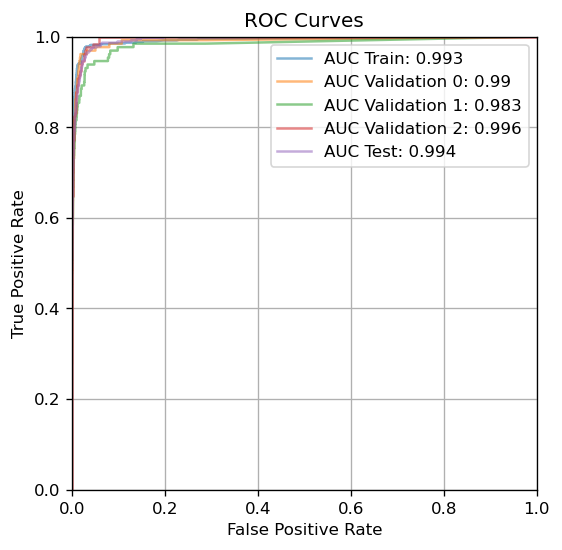

In [29]:
eval_roc_auc(lgbm_model,
             x_train=x_2_train,
             y_train=y_2_train,
             x_val=x_2_val,
             y_val=y_2_val,
             val_inds=val_inds, 
             x_test=x_test, y_test=y_test)

### PR Curve

The PR Curve is similar to ROC but this time we are interested in the `Precision` and `Recall`. `Precision` measures how much of the predicted failure events are actually failure events, whereas `Recall` measures how much of the failure events were actually captured.

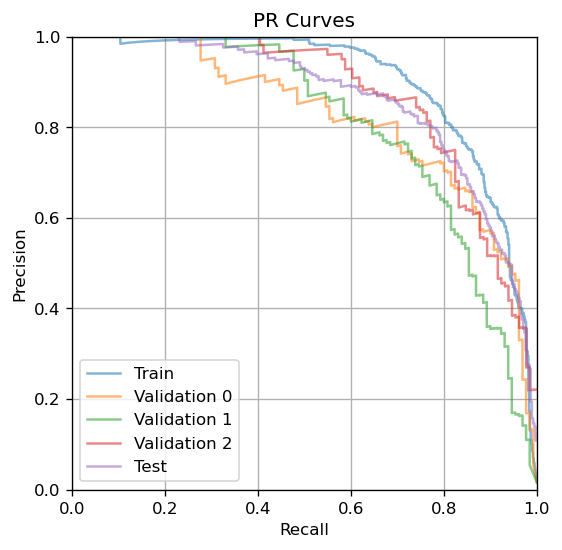

In [30]:
eval_prc(lgbm_model,
         x_train=x_2_train,
         y_train=y_2_train,
         x_val=x_2_val,
         y_val=y_2_val,
         val_inds=val_inds,
         x_test=x_test,
         y_test=y_test)

### Optimal Threshold and Associated Cost

To make this realistic of real world applications we will compute the optimal threshold using the training set and apply that threshold onto the test. The associated costs will be computed based on the predicted labels of the test set.

17060 0.035
13310 0.035


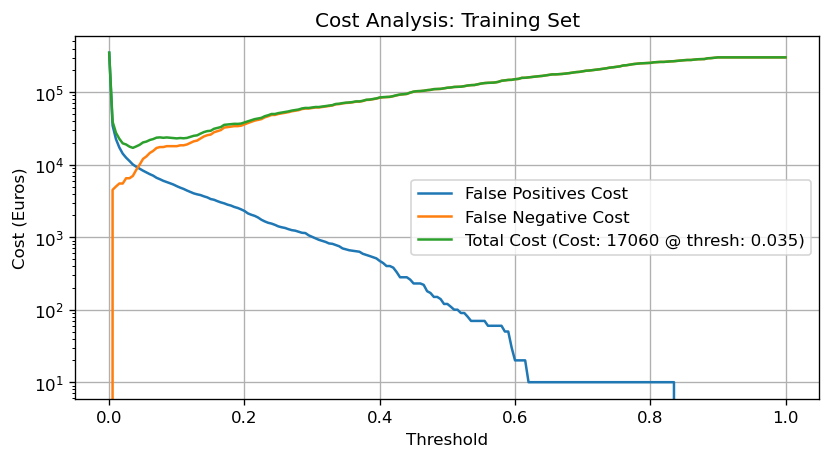

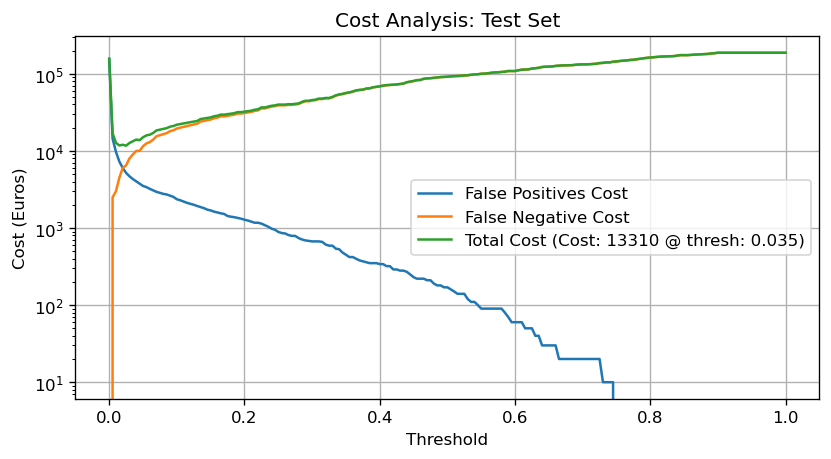

In [33]:
best_t = eval_thresh_cost(lgbm_model,
                          x=x_2_train,
                          y=y_2_train,
                          title='Cost Analysis: Training Set')

eval_thresh_cost(lgbm_model,
                 x=x_test,
                 y=y_test,
                 title='Cost Analysis: Test Set',
                 custom_thresh=best_t)

## Feature Importance

We will rely on SHAP to explain the performance of our LGBM model. The code below highlights the top 20 most relevant features based on their SHAP value. The color of the points gives a hint at the value of each variable (high or low). Note that we will still need to view the actual distribution to get a better understanding of the system's behavior.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


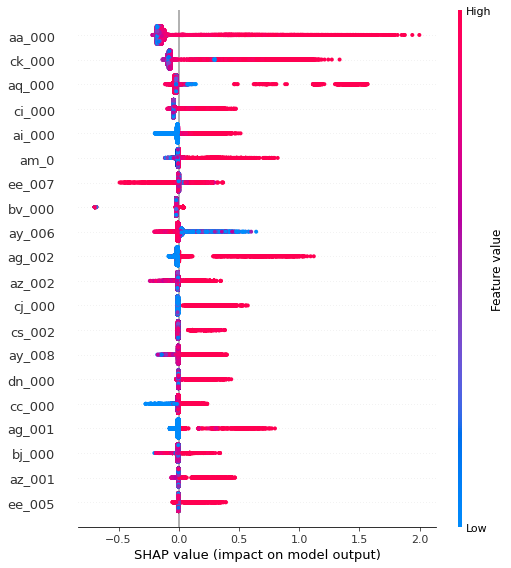

In [34]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(x_2_train)
shap.summary_plot(shap_values[1], x_2_train)

### SHAP Value Distribution per Predictor

The code below shows the distribution of the SHAP value versus the top 20 most relevant features. It can clearly be seen that above a certain point the SHAP value suddenly rises / falls. This is a common phenomenon in failure analysis, wherein a device functions normally but suddenly breaksdown when a parameter (e.g. temperature, pressure) goes above or below a certain point. It is highly likely that some of the False Positives are simply points that are very near the breakdown point.

**Unfortunately, we won't be able to do a deep dive on the features since they've been masked since they're proprietary information.**

(141,)


,col_name,feature_importance_vals
0,aa_000,0.222380
82,ck_000,0.126138
23,aq_000,0.067305
80,ci_000,0.055748
15,ai_000,0.027341
19,am_0,0.023840
136,ee_007,0.023461
72,bv_000,0.023281
36,ay_006,0.022920
6,ag_002,0.020460


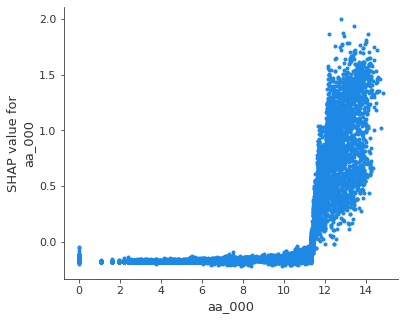

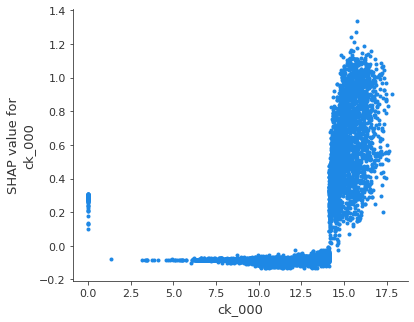

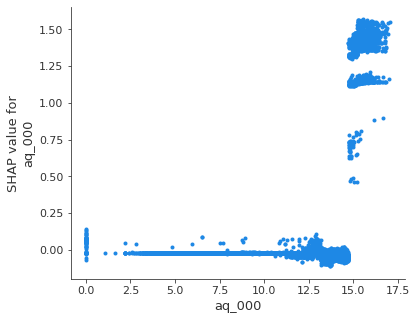

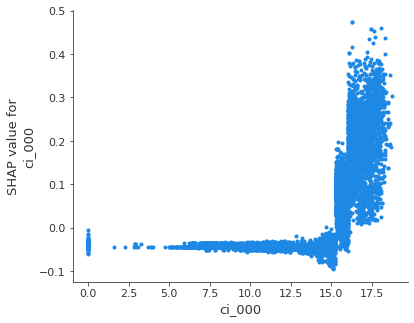

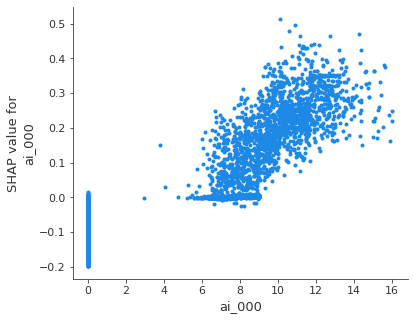

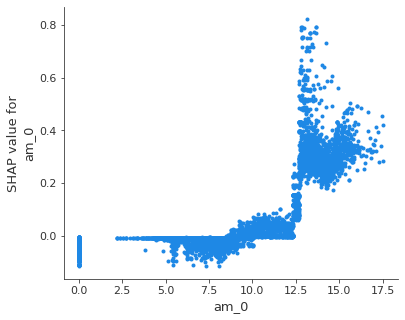

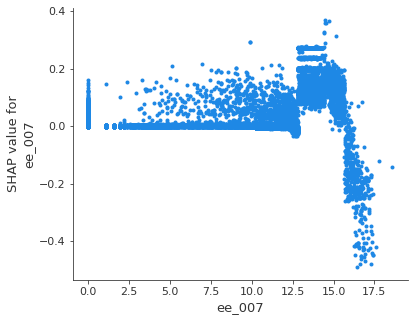

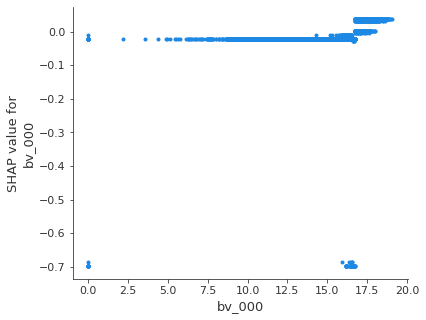

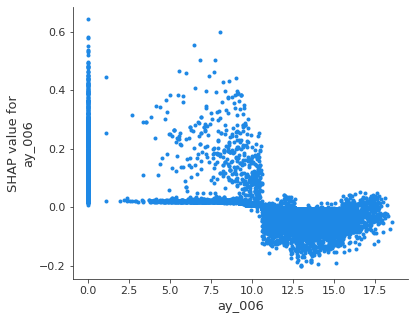

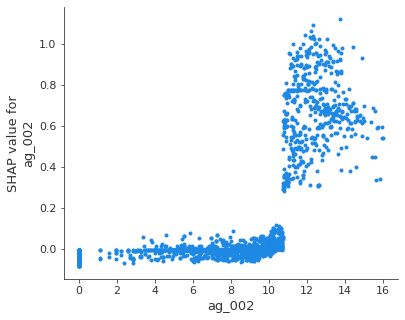

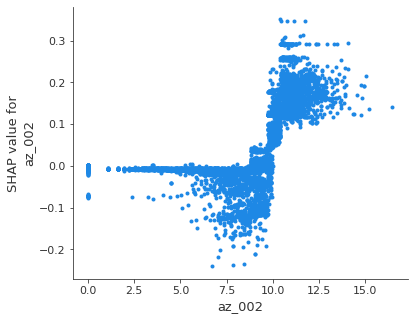

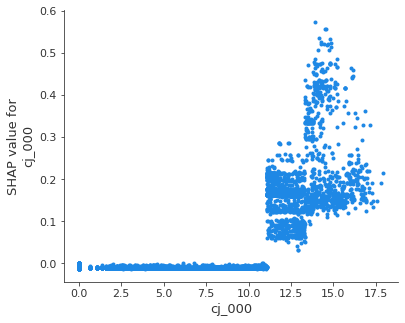

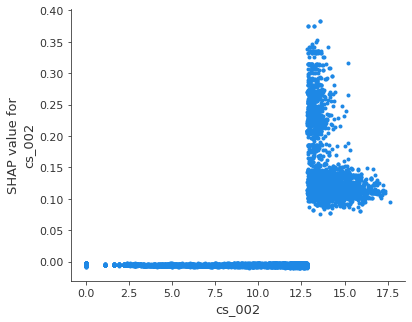

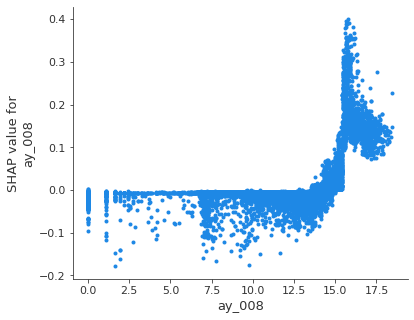

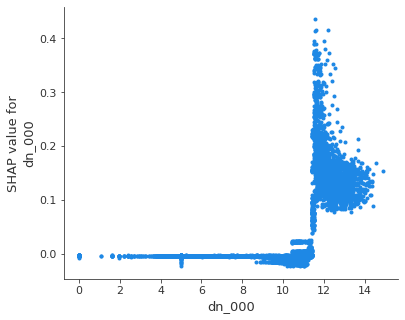

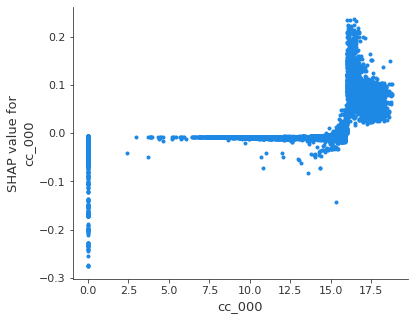

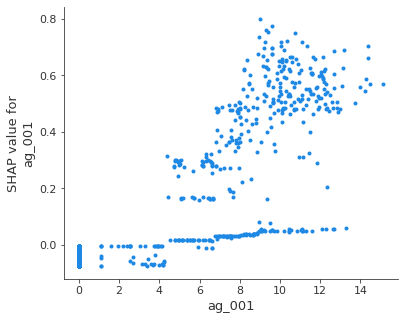

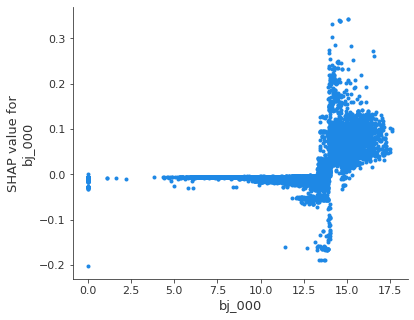

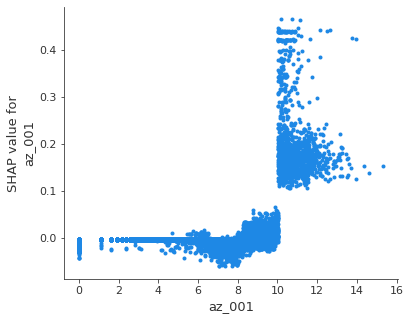

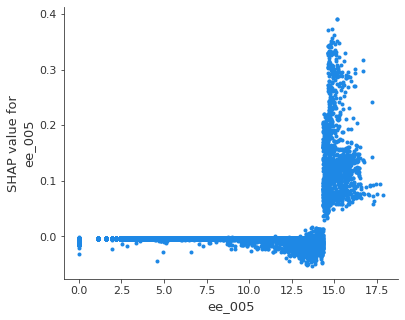

In [35]:
vals= np.abs(shap_values[1]).mean(0)
print(vals.shape)
feature_importance = pd.DataFrame(list(zip(x_2_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
display(feature_importance.head(20))

top_feats = feature_importance.head(20)['col_name']
for feat in top_feats:
    shap.dependence_plot(feat, shap_values[1], x_2_train, interaction_index=None)

## Modelling Using Less Features

Utilizing less features for the model decreases model complexity therefore making it more interpretable whilst reducing computational complexity. The code below re-runs the testing using only the top features.

In [36]:
param_grid = {'num_leaves': [70,50,30],
              'min_data_in_leaf': [35,55,75],
              'lambda_l1': [0.00001,0.0001,0.001],
              'lambda_l2': [10,100,1000],
              'bagging_fraction':[0.5],
              'feature_fraction':[0.5],
              'objective':['binary'],'path_smooth':[3],
              'max_depth':[10], 'max_bin':[150],
              'min_gain_to_split':[0.2],
              'learning_rate':[0.1],
              'num_boost_round':[1500],
              'nfold':[5],
              'early_stopping_rounds':[10]}

cv_results = estimate_hyperparameters(param_grid, x[top_feats], y)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988208 + 0.00610671
[50]	cv_agg's auc: 0.989963 + 0.00678488
[75]	cv_agg's auc: 0.990656 + 0.00606634
0


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988156 + 0.00612231
[50]	cv_agg's auc: 0.990173 + 0.00674609
1


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988034 + 0.00617987
[50]	cv_agg's auc: 0.989897 + 0.006541
[75]	cv_agg's auc: 0.990841 + 0.00547106
2


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988431 + 0.00623158
[50]	cv_agg's auc: 0.989386 + 0.00651393
[75]	cv_agg's auc: 0.990468 + 0.00555792
[100]	cv_agg's auc: 0.990971 + 0.00494219
[125]	cv_agg's auc: 0.991219 + 0.00480605
3


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988412 + 0.00622706
[50]	cv_agg's auc: 0.989843 + 0.00624977
[75]	cv_agg's auc: 0.990522 + 0.0055404
4


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988463 + 0.0061453
[50]	cv_agg's auc: 0.989856 + 0.00687658
[75]	cv_agg's auc: 0.991129 + 0.00533542
[100]	cv_agg's auc: 0.991385 + 0.00496558
5


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988793 + 0.00631264
[50]	cv_agg's auc: 0.98987 + 0.00612626
[75]	cv_agg's auc: 0.990719 + 0.00574319
6


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988793 + 0.00631264
[50]	cv_agg's auc: 0.989826 + 0.00620031
[75]	cv_agg's auc: 0.991136 + 0.0057023
7


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988654 + 0.00628628
[50]	cv_agg's auc: 0.989679 + 0.00624049
[75]	cv_agg's auc: 0.991136 + 0.00517514
8


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671439
[50]	cv_agg's auc: 0.987073 + 0.00636571
[75]	cv_agg's auc: 0.988561 + 0.00555426
[100]	cv_agg's auc: 0.98915 + 0.00568715
[125]	cv_agg's auc: 0.989611 + 0.00617899
[150]	cv_agg's auc: 0.990042 + 0.00621327
[175]	cv_agg's auc: 0.990377 + 0.0060985
[200]	cv_agg's auc: 0.99065 + 0.00593166
[225]	cv_agg's auc: 0.990864 + 0.00581368
[250]	cv_agg's auc: 0.990911 + 0.00582833
[275]	cv_agg's auc: 0.990979 + 0.00574761
[300]	cv_agg's auc: 0.991088 + 0.00560293
9


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671439
[50]	cv_agg's auc: 0.987073 + 0.00636571
[75]	cv_agg's auc: 0.988561 + 0.00555426
[100]	cv_agg's auc: 0.98915 + 0.00568715
[125]	cv_agg's auc: 0.989611 + 0.00617899
[150]	cv_agg's auc: 0.990042 + 0.00621327
[175]	cv_agg's auc: 0.990377 + 0.0060985
[200]	cv_agg's auc: 0.99065 + 0.00593166
[225]	cv_agg's auc: 0.990864 + 0.00581368
[250]	cv_agg's auc: 0.990911 + 0.00582833
[275]	cv_agg's auc: 0.990979 + 0.00574761
[300]	cv_agg's auc: 0.991088 + 0.00560293
10


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671433
[50]	cv_agg's auc: 0.987049 + 0.00633896
[75]	cv_agg's auc: 0.988451 + 0.00557044
11


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
12


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
13


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
14


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
15


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
16


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
17


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581361
[450]	cv_agg's auc: 0.98769 + 0.00586465
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600067
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581361
[450]	cv_agg's auc: 0.98769 + 0.00586465
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600067
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581361
[450]	cv_agg's auc: 0.98769 + 0.00586465
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600067
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571865
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571865
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571865
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988208 + 0.00610671
[50]	cv_agg's auc: 0.990024 + 0.00680265
[75]	cv_agg's auc: 0.990716 + 0.00607786
[100]	cv_agg's auc: 0.991184 + 0.0054953
27


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988156 + 0.00612231
[50]	cv_agg's auc: 0.990174 + 0.00674611
28


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988323 + 0.00620798
[50]	cv_agg's auc: 0.98968 + 0.00650083
[75]	cv_agg's auc: 0.990679 + 0.00547818
[100]	cv_agg's auc: 0.990949 + 0.00500444
29


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988431 + 0.00623158
[50]	cv_agg's auc: 0.989386 + 0.00651393
[75]	cv_agg's auc: 0.990468 + 0.00555792
[100]	cv_agg's auc: 0.990971 + 0.00494219
[125]	cv_agg's auc: 0.991219 + 0.00480621
30


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988412 + 0.00622706
[50]	cv_agg's auc: 0.989774 + 0.00625441
[75]	cv_agg's auc: 0.990446 + 0.00552263
31


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988463 + 0.0061453
[50]	cv_agg's auc: 0.989856 + 0.00687658
[75]	cv_agg's auc: 0.991129 + 0.00533542
[100]	cv_agg's auc: 0.991385 + 0.00496558
32


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988793 + 0.00631264
[50]	cv_agg's auc: 0.98987 + 0.00612626
[75]	cv_agg's auc: 0.990719 + 0.00574319
33


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988793 + 0.00631264
[50]	cv_agg's auc: 0.989826 + 0.00620031
[75]	cv_agg's auc: 0.991136 + 0.0057023
34


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988654 + 0.00628628
[50]	cv_agg's auc: 0.989679 + 0.00624049
[75]	cv_agg's auc: 0.991136 + 0.00517514
35


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671439
[50]	cv_agg's auc: 0.987073 + 0.00636571
[75]	cv_agg's auc: 0.988561 + 0.00555426
[100]	cv_agg's auc: 0.98915 + 0.00568715
[125]	cv_agg's auc: 0.989611 + 0.00617916
[150]	cv_agg's auc: 0.990043 + 0.0062131
[175]	cv_agg's auc: 0.990377 + 0.0060985
[200]	cv_agg's auc: 0.99065 + 0.00593166
[225]	cv_agg's auc: 0.990864 + 0.00581385
[250]	cv_agg's auc: 0.990911 + 0.00582833
[275]	cv_agg's auc: 0.990979 + 0.00574761
[300]	cv_agg's auc: 0.991088 + 0.00560293
36


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671439
[50]	cv_agg's auc: 0.987073 + 0.00636571
[75]	cv_agg's auc: 0.988561 + 0.00555426
[100]	cv_agg's auc: 0.98915 + 0.00568715
[125]	cv_agg's auc: 0.989611 + 0.00617916
[150]	cv_agg's auc: 0.990043 + 0.0062131
[175]	cv_agg's auc: 0.990377 + 0.0060985
[200]	cv_agg's auc: 0.99065 + 0.00593166
[225]	cv_agg's auc: 0.990864 + 0.00581385
[250]	cv_agg's auc: 0.990911 + 0.00582833
[275]	cv_agg's auc: 0.990979 + 0.00574761
[300]	cv_agg's auc: 0.991088 + 0.00560293
37


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671433
[50]	cv_agg's auc: 0.987049 + 0.00633896
[75]	cv_agg's auc: 0.988451 + 0.00557044
38


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
39


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
40


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
41


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
42


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
43


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619327
44


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.0065435
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553271
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550827
[325]	cv_agg's auc: 0.987128 + 0.00554539
[350]	cv_agg's auc: 0.987327 + 0.00553627
[375]	cv_agg's auc: 0.987474 + 0.00551076
[400]	cv_agg's auc: 0.98759 + 0.00552809
[425]	cv_agg's auc: 0.987622 + 0.00561065
[450]	cv_agg's auc: 0.987714 + 0.00570756
[475]	cv_agg's auc: 0.987848 + 0.00581749
[500]	cv_agg's auc: 0.988019 + 0.00586408
[525]	cv_agg's auc: 0.988192 + 0.00601133
[550]	cv_agg's auc: 0.988302 + 0.00612876
[575]	cv_agg's auc: 0.988367 + 0.00622517
[600]	cv_agg's auc: 0.988423 + 0.00632122

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581345
[450]	cv_agg's auc: 0.98769 + 0.00586482
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600052
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581345
[450]	cv_agg's auc: 0.98769 + 0.00586482
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600052
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678313
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617962
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985991 + 0.00562711
[250]	cv_agg's auc: 0.9863 + 0.00557075
[275]	cv_agg's auc: 0.986559 + 0.0055081
[300]	cv_agg's auc: 0.986726 + 0.00555123
[325]	cv_agg's auc: 0.986862 + 0.00566317
[350]	cv_agg's auc: 0.987154 + 0.00566988
[375]	cv_agg's auc: 0.98736 + 0.00562011
[400]	cv_agg's auc: 0.987502 + 0.0057032
[425]	cv_agg's auc: 0.987561 + 0.00581345
[450]	cv_agg's auc: 0.98769 + 0.00586482
[475]	cv_agg's auc: 0.987886 + 0.00587349
[500]	cv_agg's auc: 0.988056 + 0.00600052
[525]	cv_agg's auc: 0.988188 + 0.00616724
[550]	cv_agg's auc: 0.988274 + 0.00626773
[575]	cv_agg's auc: 0.988353 + 0.0063705
[600]	cv_agg's auc: 0.988401 + 0.00647311
[62

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571866
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571866
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595288
[125]	cv_agg's auc: 0.983282 + 0.00646968
[150]	cv_agg's auc: 0.983875 + 0.00694043
[175]	cv_agg's auc: 0.985075 + 0.00595987
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985928 + 0.0057761
[250]	cv_agg's auc: 0.986127 + 0.00583062
[275]	cv_agg's auc: 0.986389 + 0.00586297
[300]	cv_agg's auc: 0.986659 + 0.00578905
[325]	cv_agg's auc: 0.987014 + 0.00571866
[350]	cv_agg's auc: 0.987146 + 0.00575436
[375]	cv_agg's auc: 0.987388 + 0.00568708
[400]	cv_agg's auc: 0.987449 + 0.00576457
[425]	cv_agg's auc: 0.987562 + 0.00590331
[450]	cv_agg's auc: 0.987677 + 0.00594511
[475]	cv_agg's auc: 0.98778 + 0.00605827
[500]	cv_agg's auc: 0.987906 + 0.00611733
[525]	cv_agg's auc: 0.988008 + 0.00618249
[550]	cv_agg's auc: 0.988092 + 0.00617912
[575]	cv_agg's auc: 0.988155 + 0.00633506
[600]	cv_agg's auc: 0.988237 + 0.0064552

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988208 + 0.00610671
[50]	cv_agg's auc: 0.990035 + 0.00680539
[75]	cv_agg's auc: 0.990788 + 0.0060862
54


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988158 + 0.0061249
[50]	cv_agg's auc: 0.990151 + 0.0067286
55


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.98804 + 0.0061676
[50]	cv_agg's auc: 0.989502 + 0.00731205
[75]	cv_agg's auc: 0.990629 + 0.00590861
56


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.98843 + 0.00623125
[50]	cv_agg's auc: 0.98938 + 0.00650859
[75]	cv_agg's auc: 0.990478 + 0.00556659
[100]	cv_agg's auc: 0.990986 + 0.00499073
[125]	cv_agg's auc: 0.991211 + 0.00467073
57


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988412 + 0.00622706
[50]	cv_agg's auc: 0.989757 + 0.00624089
[75]	cv_agg's auc: 0.990473 + 0.0055449
58


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.98844 + 0.00613928
[50]	cv_agg's auc: 0.99007 + 0.00693803
[75]	cv_agg's auc: 0.99126 + 0.00525532
59


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988807 + 0.00631527
[50]	cv_agg's auc: 0.989701 + 0.00644241
[75]	cv_agg's auc: 0.990639 + 0.00598854
60


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988807 + 0.00631527
[50]	cv_agg's auc: 0.989828 + 0.0062017
[75]	cv_agg's auc: 0.991186 + 0.00570006
61


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.988654 + 0.00628627
[50]	cv_agg's auc: 0.989686 + 0.00624653
[75]	cv_agg's auc: 0.991384 + 0.00477839
62


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671454
[50]	cv_agg's auc: 0.987073 + 0.00636577
[75]	cv_agg's auc: 0.988561 + 0.00555464
[100]	cv_agg's auc: 0.989162 + 0.00566335
[125]	cv_agg's auc: 0.989694 + 0.00602229
[150]	cv_agg's auc: 0.990095 + 0.00611222
[175]	cv_agg's auc: 0.990339 + 0.00617269
[200]	cv_agg's auc: 0.990536 + 0.00615084
[225]	cv_agg's auc: 0.990718 + 0.00606162
[250]	cv_agg's auc: 0.990792 + 0.00602132
63


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983337 + 0.00671454
[50]	cv_agg's auc: 0.987073 + 0.00636577
[75]	cv_agg's auc: 0.988561 + 0.00555464
[100]	cv_agg's auc: 0.989162 + 0.00566335
[125]	cv_agg's auc: 0.989694 + 0.00602229
[150]	cv_agg's auc: 0.990095 + 0.00611222
[175]	cv_agg's auc: 0.990339 + 0.00617269
[200]	cv_agg's auc: 0.990536 + 0.00615084
[225]	cv_agg's auc: 0.990718 + 0.00606162
[250]	cv_agg's auc: 0.990792 + 0.00602132
64


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983338 + 0.00671467
[50]	cv_agg's auc: 0.987049 + 0.00633883
[75]	cv_agg's auc: 0.988451 + 0.00557042
65


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
66


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
67


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983175 + 0.00699268
68


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619328
69


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619328
70


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.983798 + 0.00699995
[50]	cv_agg's auc: 0.987536 + 0.00619328
71


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.00654347
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553266
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550818
[325]	cv_agg's auc: 0.987128 + 0.00554547
[350]	cv_agg's auc: 0.987327 + 0.00553619
[375]	cv_agg's auc: 0.987474 + 0.00551067
[400]	cv_agg's auc: 0.9876 + 0.00553417
[425]	cv_agg's auc: 0.987624 + 0.00561164
[450]	cv_agg's auc: 0.987741 + 0.00572401
[475]	cv_agg's auc: 0.987887 + 0.00583985
[500]	cv_agg's auc: 0.988028 + 0.00590938
[525]	cv_agg's auc: 0.988175 + 0.00608557
[550]	cv_agg's auc: 0.988304 + 0.00614413
[575]	cv_agg's auc: 0.988382 + 0.00623759
[600]	cv_agg's auc: 0.988457 + 0.00629711

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.00654347
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553266
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550818
[325]	cv_agg's auc: 0.987128 + 0.00554547
[350]	cv_agg's auc: 0.987327 + 0.00553619
[375]	cv_agg's auc: 0.987474 + 0.00551067
[400]	cv_agg's auc: 0.9876 + 0.00553417
[425]	cv_agg's auc: 0.987624 + 0.00561164
[450]	cv_agg's auc: 0.987741 + 0.00572401
[475]	cv_agg's auc: 0.987887 + 0.00583985
[500]	cv_agg's auc: 0.988028 + 0.00590938
[525]	cv_agg's auc: 0.988175 + 0.00608557
[550]	cv_agg's auc: 0.988304 + 0.00614413
[575]	cv_agg's auc: 0.988382 + 0.00623759
[600]	cv_agg's auc: 0.988457 + 0.00629711

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973541 + 0.00654589
[50]	cv_agg's auc: 0.977539 + 0.0060007
[75]	cv_agg's auc: 0.981035 + 0.00582665
[100]	cv_agg's auc: 0.982636 + 0.00600257
[125]	cv_agg's auc: 0.983378 + 0.00654347
[150]	cv_agg's auc: 0.985101 + 0.00594011
[175]	cv_agg's auc: 0.98519 + 0.00605833
[200]	cv_agg's auc: 0.985827 + 0.00579305
[225]	cv_agg's auc: 0.986147 + 0.00570616
[250]	cv_agg's auc: 0.986465 + 0.00553266
[275]	cv_agg's auc: 0.986671 + 0.00545641
[300]	cv_agg's auc: 0.986831 + 0.00550818
[325]	cv_agg's auc: 0.987128 + 0.00554547
[350]	cv_agg's auc: 0.987327 + 0.00553619
[375]	cv_agg's auc: 0.987474 + 0.00551067
[400]	cv_agg's auc: 0.9876 + 0.00553417
[425]	cv_agg's auc: 0.987624 + 0.00561164
[450]	cv_agg's auc: 0.987741 + 0.00572401
[475]	cv_agg's auc: 0.987887 + 0.00583985
[500]	cv_agg's auc: 0.988028 + 0.00590938
[525]	cv_agg's auc: 0.988175 + 0.00608557
[550]	cv_agg's auc: 0.988304 + 0.00614413
[575]	cv_agg's auc: 0.988382 + 0.00623759
[600]	cv_agg's auc: 0.988457 + 0.00629711

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678305
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617953
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985992 + 0.00562665
[250]	cv_agg's auc: 0.986295 + 0.00556887
[275]	cv_agg's auc: 0.986507 + 0.00548199
[300]	cv_agg's auc: 0.986667 + 0.00551835
[325]	cv_agg's auc: 0.986839 + 0.00565121
[350]	cv_agg's auc: 0.987088 + 0.00565061
[375]	cv_agg's auc: 0.98731 + 0.00560262
[400]	cv_agg's auc: 0.987466 + 0.00569473
[425]	cv_agg's auc: 0.987528 + 0.0057896
[450]	cv_agg's auc: 0.987687 + 0.00585709
[475]	cv_agg's auc: 0.9879 + 0.00586642
[500]	cv_agg's auc: 0.988072 + 0.00599702
[525]	cv_agg's auc: 0.988199 + 0.0061639
[550]	cv_agg's auc: 0.988291 + 0.00626334
[575]	cv_agg's auc: 0.988368 + 0.00636454
[600]	cv_agg's auc: 0.988425 + 0.00647775
[

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678305
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617953
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985992 + 0.00562665
[250]	cv_agg's auc: 0.986295 + 0.00556887
[275]	cv_agg's auc: 0.986507 + 0.00548199
[300]	cv_agg's auc: 0.986667 + 0.00551835
[325]	cv_agg's auc: 0.986839 + 0.00565121
[350]	cv_agg's auc: 0.987088 + 0.00565061
[375]	cv_agg's auc: 0.98731 + 0.00560262
[400]	cv_agg's auc: 0.987466 + 0.00569473
[425]	cv_agg's auc: 0.987528 + 0.0057896
[450]	cv_agg's auc: 0.987687 + 0.00585709
[475]	cv_agg's auc: 0.9879 + 0.00586642
[500]	cv_agg's auc: 0.988072 + 0.00599702
[525]	cv_agg's auc: 0.988199 + 0.0061639
[550]	cv_agg's auc: 0.988291 + 0.00626334
[575]	cv_agg's auc: 0.988368 + 0.00636454
[600]	cv_agg's auc: 0.988425 + 0.00647775
[

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973589 + 0.00648295
[50]	cv_agg's auc: 0.977522 + 0.00586294
[75]	cv_agg's auc: 0.98101 + 0.00586324
[100]	cv_agg's auc: 0.982682 + 0.00604708
[125]	cv_agg's auc: 0.983638 + 0.00678305
[150]	cv_agg's auc: 0.984642 + 0.00636012
[175]	cv_agg's auc: 0.985208 + 0.00617953
[200]	cv_agg's auc: 0.985772 + 0.00559001
[225]	cv_agg's auc: 0.985992 + 0.00562665
[250]	cv_agg's auc: 0.986295 + 0.00556887
[275]	cv_agg's auc: 0.986507 + 0.00548199
[300]	cv_agg's auc: 0.986667 + 0.00551835
[325]	cv_agg's auc: 0.986839 + 0.00565121
[350]	cv_agg's auc: 0.987088 + 0.00565061
[375]	cv_agg's auc: 0.98731 + 0.00560262
[400]	cv_agg's auc: 0.987466 + 0.00569473
[425]	cv_agg's auc: 0.987528 + 0.0057896
[450]	cv_agg's auc: 0.987687 + 0.00585709
[475]	cv_agg's auc: 0.9879 + 0.00586642
[500]	cv_agg's auc: 0.988072 + 0.00599702
[525]	cv_agg's auc: 0.988199 + 0.0061639
[550]	cv_agg's auc: 0.988291 + 0.00626334
[575]	cv_agg's auc: 0.988368 + 0.00636454
[600]	cv_agg's auc: 0.988425 + 0.00647775
[

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595275
[125]	cv_agg's auc: 0.983282 + 0.00646983
[150]	cv_agg's auc: 0.983875 + 0.0069403
[175]	cv_agg's auc: 0.985075 + 0.0059597
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985929 + 0.00577667
[250]	cv_agg's auc: 0.986129 + 0.00583302
[275]	cv_agg's auc: 0.986387 + 0.00586024
[300]	cv_agg's auc: 0.986653 + 0.00578305
[325]	cv_agg's auc: 0.987007 + 0.00571154
[350]	cv_agg's auc: 0.987146 + 0.00575504
[375]	cv_agg's auc: 0.98738 + 0.00567934
[400]	cv_agg's auc: 0.987444 + 0.0057597
[425]	cv_agg's auc: 0.987559 + 0.00590031
[450]	cv_agg's auc: 0.98768 + 0.00594817
[475]	cv_agg's auc: 0.987782 + 0.00606048
[500]	cv_agg's auc: 0.987912 + 0.00612307
[525]	cv_agg's auc: 0.988009 + 0.00618338
[550]	cv_agg's auc: 0.988112 + 0.00619194
[575]	cv_agg's auc: 0.988161 + 0.00634012
[600]	cv_agg's auc: 0.988246 + 0.00646202
[

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595275
[125]	cv_agg's auc: 0.983282 + 0.00646983
[150]	cv_agg's auc: 0.983875 + 0.0069403
[175]	cv_agg's auc: 0.985075 + 0.0059597
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985929 + 0.00577667
[250]	cv_agg's auc: 0.986129 + 0.00583302
[275]	cv_agg's auc: 0.986387 + 0.00586024
[300]	cv_agg's auc: 0.986653 + 0.00578305
[325]	cv_agg's auc: 0.987007 + 0.00571154
[350]	cv_agg's auc: 0.987146 + 0.00575504
[375]	cv_agg's auc: 0.98738 + 0.00567934
[400]	cv_agg's auc: 0.987444 + 0.0057597
[425]	cv_agg's auc: 0.987559 + 0.00590031
[450]	cv_agg's auc: 0.98768 + 0.00594817
[475]	cv_agg's auc: 0.987782 + 0.00606048
[500]	cv_agg's auc: 0.987912 + 0.00612307
[525]	cv_agg's auc: 0.988009 + 0.00618338
[550]	cv_agg's auc: 0.988112 + 0.00619194
[575]	cv_agg's auc: 0.988161 + 0.00634012
[600]	cv_agg's auc: 0.988246 + 0.00646202
[

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[25]	cv_agg's auc: 0.973922 + 0.00632022
[50]	cv_agg's auc: 0.977457 + 0.0059704
[75]	cv_agg's auc: 0.981034 + 0.00581857
[100]	cv_agg's auc: 0.982612 + 0.00595275
[125]	cv_agg's auc: 0.983282 + 0.00646983
[150]	cv_agg's auc: 0.983875 + 0.0069403
[175]	cv_agg's auc: 0.985075 + 0.0059597
[200]	cv_agg's auc: 0.985476 + 0.00598528
[225]	cv_agg's auc: 0.985929 + 0.00577667
[250]	cv_agg's auc: 0.986129 + 0.00583302
[275]	cv_agg's auc: 0.986387 + 0.00586024
[300]	cv_agg's auc: 0.986653 + 0.00578305
[325]	cv_agg's auc: 0.987007 + 0.00571154
[350]	cv_agg's auc: 0.987146 + 0.00575504
[375]	cv_agg's auc: 0.98738 + 0.00567934
[400]	cv_agg's auc: 0.987444 + 0.0057597
[425]	cv_agg's auc: 0.987559 + 0.00590031
[450]	cv_agg's auc: 0.98768 + 0.00594817
[475]	cv_agg's auc: 0.987782 + 0.00606048
[500]	cv_agg's auc: 0.987912 + 0.00612307
[525]	cv_agg's auc: 0.988009 + 0.00618338
[550]	cv_agg's auc: 0.988112 + 0.00619194
[575]	cv_agg's auc: 0.988161 + 0.00634012
[600]	cv_agg's auc: 0.988246 + 0.00646202
[

In [39]:
x_2_train , x_2_val, y_2_train, y_2_val, val_inds, validation_sets = perform_splits(x[top_feats],y)

params = cv_results[0][0]
params['metric'] = ['auc']

# Model
lgbm_model = lgb.train(params, Dataset(x_2_train, label=y_2_train),
                       valid_sets=validation_sets,
                       verbose_eval=25)

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
[25]	valid_0's auc: 0.993638	valid_1's auc: 0.982282	valid_2's auc: 0.984338
[50]	valid_0's auc: 0.995173	valid_1's auc: 0.989393	valid_2's auc: 0.990091
Early stopping, best iteration is:
[48]	valid_0's auc: 0.995088	valid_1's auc: 0.989392	valid_2's auc: 0.990327


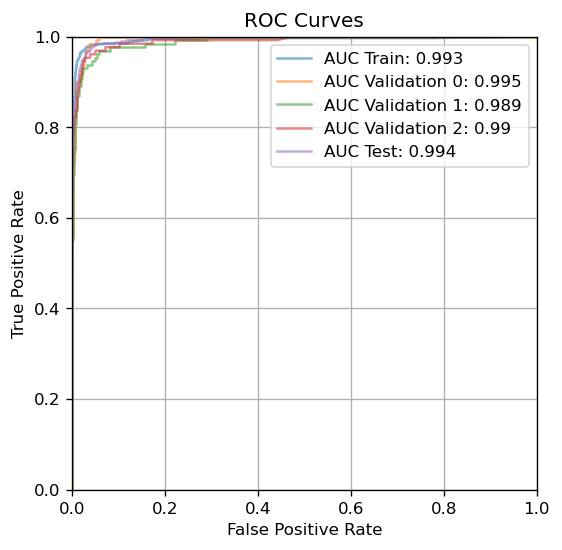

In [41]:
eval_roc_auc(lgbm_model,
             x_train=x_2_train,
             y_train=y_2_train,
             x_val=x_2_val,
             y_val=y_2_val,
             val_inds=val_inds, 
             x_test=x_test[top_feats], y_test=y_test)

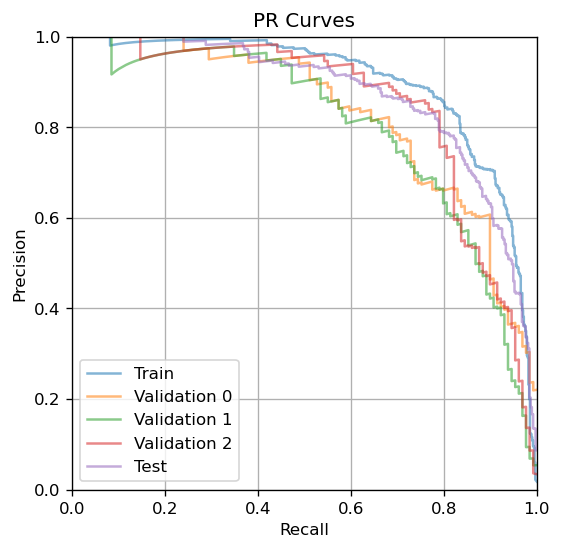

In [42]:
eval_prc(lgbm_model,
         x_train=x_2_train,
         y_train=y_2_train,
         x_val=x_2_val,
         y_val=y_2_val,
         val_inds=val_inds,
         x_test=x_test[top_feats],
         y_test=y_test)

17130 0.06
15560 0.06


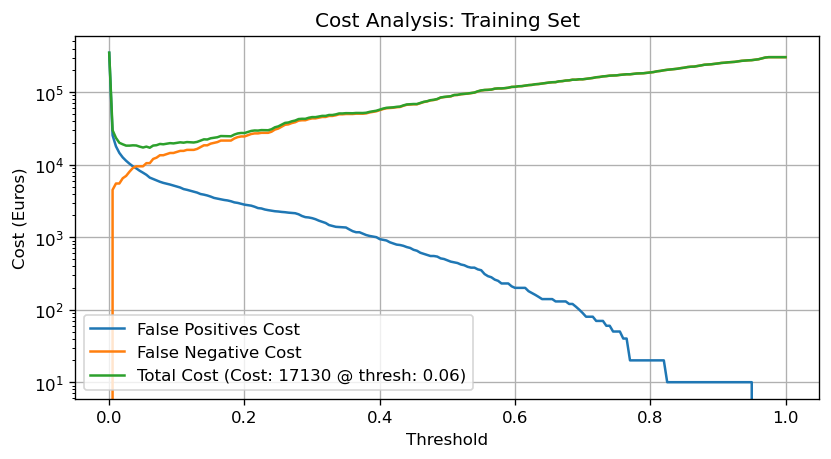

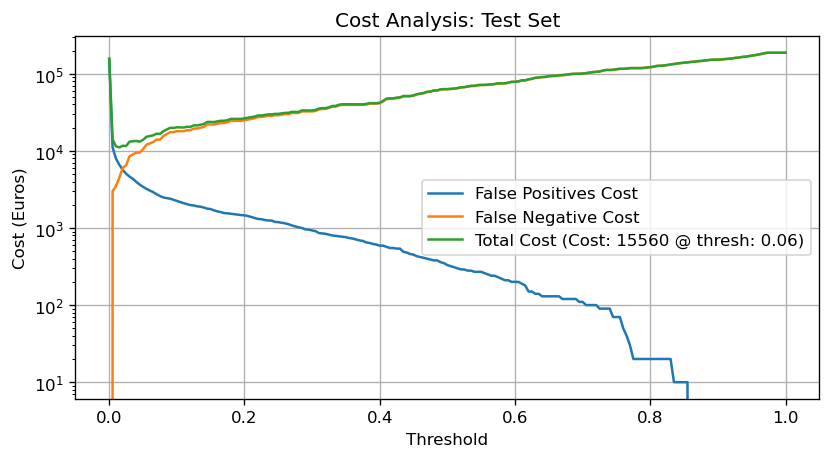

In [43]:
best_t = eval_thresh_cost(lgbm_model,
                          x=x_2_train,
                          y=y_2_train,
                          title='Cost Analysis: Training Set')

eval_thresh_cost(lgbm_model,
                 x=x_test[top_feats],
                 y=y_test,
                 title='Cost Analysis: Test Set',
                 custom_thresh=best_t)

In [308]:
from itertools import combinations
from sklearn.decomposition import PCA

In [363]:
df_x_2_feats = pd.DataFrame()
for col1, col2 in combinations(x_2[top_feats].columns, 2):
    df_x_2_feats[col1] = x_2[col1]
    df_x_2_feats[col2] = x_2[col2]
    df_x_2_feats[col1+'_'+col2] = x_2[col1].values / (x_2[col2].values+0.000000000000001)

In [364]:
df_x_test_feats = pd.DataFrame()
for col1, col2 in combinations(x_test[top_feats].columns, 2):
    df_x_test_feats[col1] = x_test[col1]
    df_x_test_feats[col2] = x_test[col2]
    df_x_test_feats[col1+'_'+col2] = x_test[col1].values / (x_test[col2].values+0.000000000000001)

In [378]:
df_x_2_feats.shape

(59324, 210)

In [389]:
pca_model = PCA(n_components=20)
x_2_engr = pca_model.fit_transform(df_x_2_feats)
x_2_engr.shape

(59324, 20)

In [390]:
sum(pca_model.explained_variance_ratio_)

0.9789951788473437

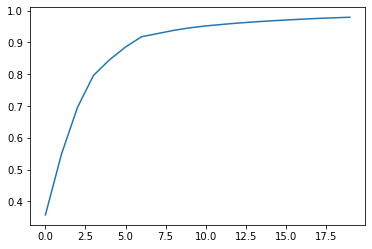

In [391]:
plt.plot(np.cumsum(pca_model.explained_variance_ratio_));
np.cumsum(pca_model.explained_variance_ratio_);

In [392]:
x_test_engr = pca_model.transform(df_x_test_feats)

In [406]:
param_grid = {'num_leaves': [70,50,30],
              'min_data_in_leaf': [35,55,75],
              'lambda_l1': [0.00001,0.0001,0.001],
              'lambda_l2': [10,100,1000],
              'bagging_fraction':[0.5],
              'feature_fraction':[0.5],
              'objective':['binary'],'path_smooth':[3],
              'max_depth':[10], 'max_bin':[150],
              'min_gain_to_split':[0.2],
              'learning_rate':[0.1]}

cv_results = []
for i,hyperparams in enumerate(list(ParameterGrid(param_grid))):
    
    validation_summary = lgb.cv(hyperparams,
                                Dataset(df_x_2_feats, label=y_2),
                                num_boost_round=1500,
                                nfold=5,
                                metrics=["auc"],
                                early_stopping_rounds=10,
                                verbose_eval=25, seed=42)
    
    # Store the best hyperparameters
    cv_results.append((hyperparams, validation_summary["auc-mean"][-1]))
    
    print(i)

[25]	cv_agg's auc: 0.988138 + 0.00609074
0
[25]	cv_agg's auc: 0.988305 + 0.00616318
1
[25]	cv_agg's auc: 0.987451 + 0.00636639
2
[25]	cv_agg's auc: 0.98827 + 0.00636066
3
[25]	cv_agg's auc: 0.98824 + 0.00633214
[50]	cv_agg's auc: 0.990514 + 0.00612636
[75]	cv_agg's auc: 0.991065 + 0.00566935
4
[25]	cv_agg's auc: 0.988242 + 0.00661536
[50]	cv_agg's auc: 0.990121 + 0.00653801
5
[25]	cv_agg's auc: 0.988297 + 0.00633892
[50]	cv_agg's auc: 0.990499 + 0.0053661
6
[25]	cv_agg's auc: 0.988298 + 0.00633899
[50]	cv_agg's auc: 0.990412 + 0.00597599
7
[25]	cv_agg's auc: 0.988224 + 0.00630786
[50]	cv_agg's auc: 0.989877 + 0.00597818
[75]	cv_agg's auc: 0.990591 + 0.00565092
8
[25]	cv_agg's auc: 0.985052 + 0.00561534
[50]	cv_agg's auc: 0.988114 + 0.00557985
[75]	cv_agg's auc: 0.988821 + 0.00488728
[100]	cv_agg's auc: 0.98952 + 0.00449891
[125]	cv_agg's auc: 0.989901 + 0.00444034
[150]	cv_agg's auc: 0.990254 + 0.00428775
[175]	cv_agg's auc: 0.990597 + 0.00420728
9
[25]	cv_agg's auc: 0.985052 + 0.00561

[75]	cv_agg's auc: 0.983689 + 0.00459555
[100]	cv_agg's auc: 0.985204 + 0.00476733
[125]	cv_agg's auc: 0.986075 + 0.00496212
[150]	cv_agg's auc: 0.986895 + 0.0043182
[175]	cv_agg's auc: 0.986926 + 0.00422391
45
[25]	cv_agg's auc: 0.975901 + 0.00728649
[50]	cv_agg's auc: 0.980949 + 0.00504168
[75]	cv_agg's auc: 0.983689 + 0.00459555
[100]	cv_agg's auc: 0.985204 + 0.00476733
[125]	cv_agg's auc: 0.986075 + 0.00496212
[150]	cv_agg's auc: 0.986895 + 0.0043182
[175]	cv_agg's auc: 0.986926 + 0.00422391
46
[25]	cv_agg's auc: 0.975901 + 0.00728649
[50]	cv_agg's auc: 0.980949 + 0.00504168
[75]	cv_agg's auc: 0.983689 + 0.00459555
[100]	cv_agg's auc: 0.985204 + 0.00476733
[125]	cv_agg's auc: 0.986075 + 0.00496212
[150]	cv_agg's auc: 0.986895 + 0.0043182
[175]	cv_agg's auc: 0.986926 + 0.00422391
47
[25]	cv_agg's auc: 0.975867 + 0.00732844
[50]	cv_agg's auc: 0.980968 + 0.00508521
[75]	cv_agg's auc: 0.983784 + 0.00460079
[100]	cv_agg's auc: 0.985255 + 0.00481071
[125]	cv_agg's auc: 0.986118 + 0.00497

In [408]:
params = sorted(cv_results, key=lambda x: x[1], reverse=True)[0][0]
params['metric'] = ["auc"]
params['num_boost_round'] = 1500
params['nfold'] = 5
params['early_stopping_rounds'] = 10
params['verbose_eval'] = 25

x_2_train, x_2_val, y_2_train, y_2_val = train_test_split(df_x_2_feats, y_2, test_size=0.4)


x_2_train.columns = df_x_2_feats.columns
x_2_val.columns = df_x_2_feats.columns

# StratifiedKFold executes the k-fold operation in a stratified manner
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(x_2_val, y_2_val)

# Get the validation sets
val_inds = [tst for trn, tst in skf.split(x_2_val, y_2_val)]

print(val_inds)
validation_sets = [Dataset(x_2_val.values[val_ind],
                           label=y_2_val.values[val_ind])
                   for val_ind in val_inds]

# Model
lgbm_model = lgb.train(params, Dataset(x_2_train,
                                       label=y_2_train),
                       valid_sets=validation_sets)

[array([   0,    1,    2, ..., 8191, 8204, 8246]), array([ 7904,  7905,  7906, ..., 15817, 15818, 15819]), array([15820, 15821, 15822, ..., 23727, 23728, 23729])]


Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[1]	valid_0's auc: 0.958798	valid_1's auc: 0.958665	valid_2's auc: 0.972221
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.964243	valid_1's auc: 0.970243	valid_2's auc: 0.976905
[3]	valid_0's auc: 0.964678	valid_1's auc: 0.971573	valid_2's auc: 0.977609
[4]	valid_0's auc: 0.96604	valid_1's auc: 0.973249	valid_2's auc: 0.981968
[5]	valid_0's auc: 0.966585	valid_1's auc: 0.973835	valid_2's auc: 0.986156
[6]	valid_0's auc: 0.967117	valid_1's auc: 0.974278	valid_2's auc: 0.986453
[7]	valid_0's auc: 0.967069	valid_1's auc: 0.974315	valid_2's auc: 0.986578
[8]	valid_0's auc: 0.970814	valid_1's auc: 0.974494	valid_2's auc: 0.987316
[9]	valid_0's auc: 0.971094	valid_1's auc: 0.97462	valid_2's auc: 0.987467
[10]	valid_0's auc: 0.971374	valid_1's auc: 0.974723	valid_2's auc: 0.987817
[11]	valid_0's auc: 0.971427	valid_1's auc: 0.974754	valid_2's auc: 0.987849
[12]	valid_0's auc: 0.97158	valid_1's auc: 0.9751	valid_2's auc: 0.987945
[13]	valid_0's auc: 0.971497	

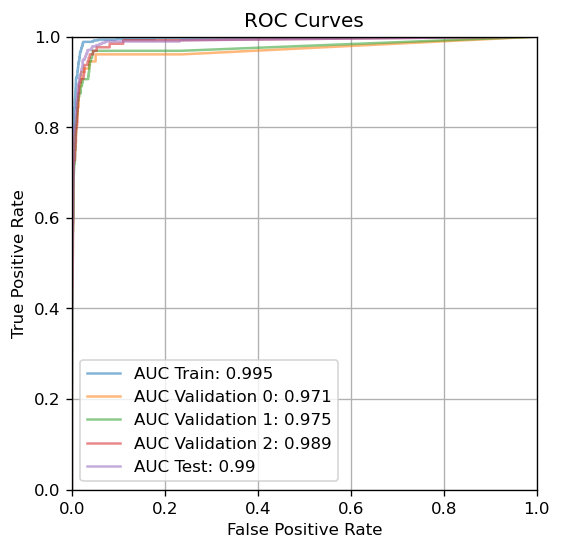

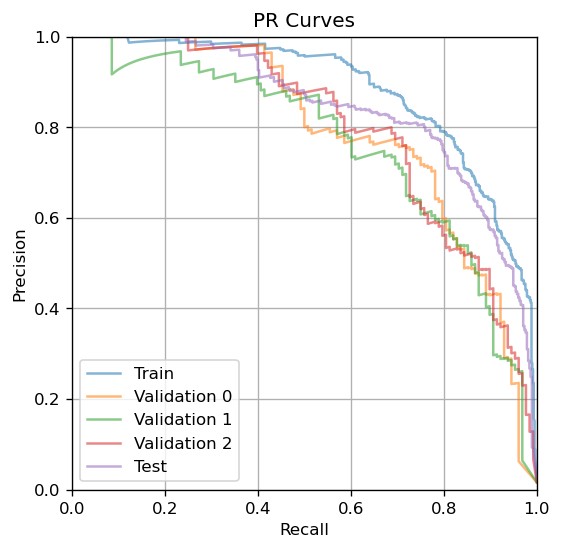

In [409]:

eval_roc_auc(lgbm_model,
             x_train=x_2_train,
             y_train=y_2_train,
             x_val=x_2_val,
             y_val=y_2_val,
             val_inds=val_inds, 
             x_test=df_x_test_feats, y_test=y_test)

eval_prc(lgbm_model,
         x_train=x_2_train,
         y_train=y_2_train,
         x_val=x_2_val,
         y_val=y_2_val,
         val_inds=val_inds,
         x_test=df_x_test_feats,
         y_test=y_test)

12470 0.035


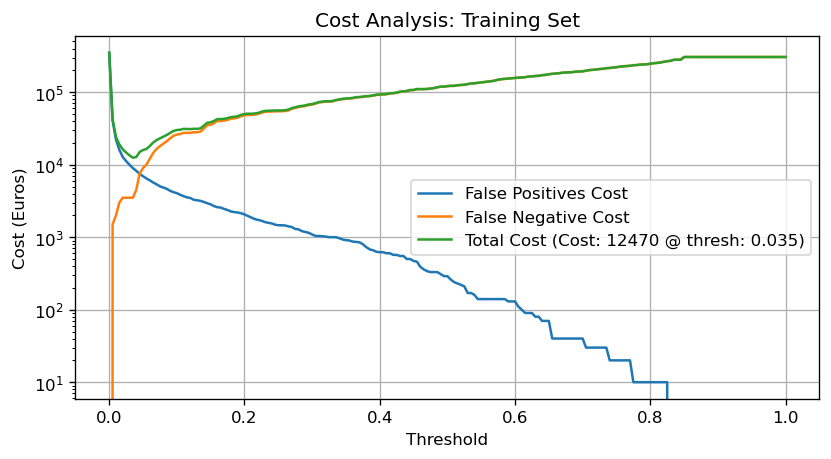

In [410]:
eval_thresh_cost(lgbm_model,
                 x=x_2_train,
                 y=y_2_train,
                 title='Cost Analysis: Training Set')

# eval_thresh_cost(lgbm_model,
#                  x=df_x_test_feats,
#                  y=y_test,
#                  title='Cost Analysis: Test Set',
#                  custom_thresh=0.04)

13320 0.035


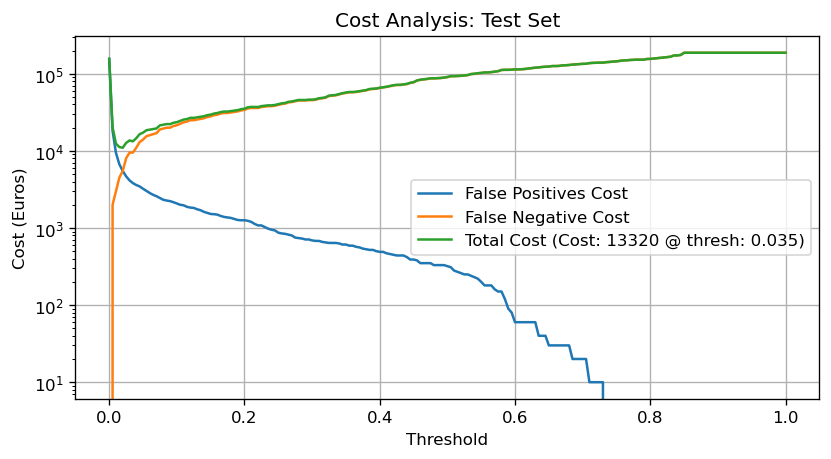

In [411]:
eval_thresh_cost(lgbm_model,
                 x=df_x_test_feats,
                 y=y_test,
                 title='Cost Analysis: Test Set',
                 custom_thresh=0.035)